# Cloud Computing - Business Case
`Author : Raquel Santiago`

`Date : 07/10/2023`

## Objective
- mitigate cloud computing cost
- understand which spend areas are going to cause growth, in order to prioritize specific AWS services for optimization efforts

```
Your deliverables include:
- Your forecast:
o A report summarizing your analysis & modeling approach, including visualizations & key insights
o A forecast of spend broken down by Product (Product (tag)) for the next six months - you can decide on the granularity (both time & which attributes to use) and method
o Code and documentation for the model, including any preprocessing steps, feature engineering, and model selection.
- Based on your forecast, lay out the main drivers of spend increase for the client, and whether you believe they should be prioritized for optimization efforts. This can be in terms of the client’s infrastructure components (product (tag) & environment (tag)), or the AWS service information, or both!
```

## Overview
- suite of models for improved forecasting & spend visibility
- data: cost & billing usage report for the past 18 months

## Model Proposal 
#### (try all model approaches, for results comparison, if time permits)
- Anomaly Detection with Time Series Forecasting
    - Prophet
    - Statistical Profiling Approach
    - Clustering Based Unsupervised Approach

______________________________________________________________________

# Setup Environment

## Add utils

In [47]:
import os, sys
repo_path = os.path.abspath(os.path.join('..', '..', '..'))
sys.path.append(repo_path)
print(repo_path)

/


## Confirm virtual environment

In [48]:
print(sys.prefix)
print(sys.executable)

/mnt/N0326018/.venv
/mnt/N0326018/.venv/bin/python


In [49]:
# list files
!ls

data			     README.md
Datalab_Task_20220622.ipynb  reuse
output			     rs-cloud-analytics-modeling.html
Pipfile			     rs-cloud-analytics-modeling.ipynb
Pipfile.lock		     shared


In [50]:
# list all files (confirm .venv folder)
!ls -al

total 5912
drwxr-x---. 15 N0326018 wheel       4096 Oct 10 23:33 .
drwxr-xr-x. 10 root     root        4096 Sep 24 12:53 ..
-rw-------.  1 N0326018 wheel         88 Oct  9 23:00 .bash_history
-rw-r--r--.  1 N0326018 wheel         18 Jul 15  2020 .bash_logout
-rw-r--r--.  1 N0326018 wheel        193 Jul 15  2020 .bash_profile
-rw-r--r--.  1 N0326018 wheel        742 Oct  7 13:59 .bashrc
drwxr-xr-x. 10 N0326018 wheel       4096 Oct  7 15:07 .cache
drwxrwsr-x.  2 N0326018 wheel       4096 Oct  7 14:02 .conda
drwx------.  4 N0326018 wheel       4096 Oct  7 15:07 .config
drwxr-xr-x.  3 N0326018 wheel       4096 Oct  7 13:43 data
-rw-r--r--.  1 N0326018 wheel      45969 Oct 10 23:31 Datalab_Task_20220622.ipynb
drwxr-xr-x.  2 N0326018 wheel       4096 Oct 10 23:32 .ipynb_checkpoints
drwxr-xr-x.  3 N0326018 wheel       4096 Sep 24 12:57 .ipython
drwxr-xr-x.  4 N0326018 wheel       4096 Oct  7 15:36 .jupyter
drwxr-xr-x.  3 N0326018 wheel       4096 Sep 24 12:53 .local
drwxr-xr-x. 12 N0326018 N0

## Libraries

In [51]:
import logging
logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s.%(msecs)03d - %(levelname)s : %(message)s',
        datefmt='%H:%M:%S')
logger = logging.getLogger(__name__)

import pandas as pd
import numpy
import time
from datetime import date, datetime, timedelta
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import ydata_profiling
import sweetviz as sv
import plotly.express as px

from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_absolute_percentage_error, mean_squared_error
from math import sqrt

## Setup info

In [52]:
# Config display options
pd.options.display.max_colwidth = 10000
pd.options.display.float_format = '{:.2f}'.format

# Display all outputs in Jupyter Notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# I want pandas to show all columns and up to * rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)

# Environment for images
# This sets reasonable defaults for font size for
# a figure that will go in a notebook
sns.set_context("notebook")

# Set the font to be serif, rather than sans
sns.set(font='serif')

# Make the background white, and specify the
# specific font family
sns.set_style("whitegrid")

______________________________________________________________________

# Load Training Dataset

In [53]:
data = pd.read_csv('data/cost_data.csv', sep='|', encoding='utf-8')

In [54]:
data.head()
data.info()

usage_date line item type      product code  \
0  2021-10-10          Usage         AmazonEC2   
1  2021-10-11          Usage  AmazonCloudWatch   
2  2021-10-12          Usage          AmazonS3   
3  2021-10-25          Usage            AWSELB   
4  2021-10-02          Usage          AmazonS3   

                                                                         line item description  \
0  $0.010 per GB - regional data transfer - in/out/between EC2 AZs or using elastic IPs or ELB   
1                                 $0.03 per GB-mo of log storage - US East (Northern Virginia)   
2                                                 $0.004 per 10,000 GET and all other requests   
3               $0.008 per used Application load balancer capacity unit-hour (or partial hour)   
4                                                 $0.004 per 10,000 GET and all other requests   

      usage type             usage type (aws)                  operation  \
0    Data Volume  DataTransfer-Regional-Bytes              InterZone-Out   
1        Storage    USE1-TimedStorage-ByteHrs      HourlyStorageMetering   
2     Operations               Requests-Tier2    ReadRequestPaymentProps   
3  Capacity Hour                     LCUUsage  LoadBalancing:Application   
4     Operations               Requests-Tier2          WebsiteHeadObject   

  environment (tag) product (tag)  amortized_cost  usage_amount  
0               NaN     Product 5            2.46        245.99  
1               NaN     Product 5            1.51         50.46  
2               NaN     Product 5            0.00        620.00  
3               NaN     Product 5            0.19         23.41  
4               NaN     Product 5            0.00          1.00

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1719914 entries, 0 to 1719913
Data columns (total 11 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   usage_date             object 
 1   line item type         object 
 2   product code           object 
 3   line item description  object 
 4   usage type             object 
 5   usage type (aws)       object 
 6   operation              object 
 7   environment (tag)      object 
 8   product (tag)          object 
 9   amortized_cost         float64
 10  usage_amount           float64
dtypes: float64(2), object(9)
memory usage: 144.3+ MB


______________________________________________________________________

# Data Processing and Analysis

## Exploratory Data Analysis

In [55]:
# rename columns
data.rename(columns={'line item type':'line_item_type',
                     'product code':'product_code',
                     'line item description':'line_item_description',
                     'usage type':'usage_type',
                     'usage type (aws)':'usage_type_aws',
                     'environment (tag)':'environment_tag',
                     'product (tag)':'product_tag'},
            inplace=True)
data.head()

usage_date line_item_type      product_code  \
0  2021-10-10          Usage         AmazonEC2   
1  2021-10-11          Usage  AmazonCloudWatch   
2  2021-10-12          Usage          AmazonS3   
3  2021-10-25          Usage            AWSELB   
4  2021-10-02          Usage          AmazonS3   

                                                                         line_item_description  \
0  $0.010 per GB - regional data transfer - in/out/between EC2 AZs or using elastic IPs or ELB   
1                                 $0.03 per GB-mo of log storage - US East (Northern Virginia)   
2                                                 $0.004 per 10,000 GET and all other requests   
3               $0.008 per used Application load balancer capacity unit-hour (or partial hour)   
4                                                 $0.004 per 10,000 GET and all other requests   

      usage_type               usage_type_aws                  operation  \
0    Data Volume  DataTransfer-Regional-Bytes              InterZone-Out   
1        Storage    USE1-TimedStorage-ByteHrs      HourlyStorageMetering   
2     Operations               Requests-Tier2    ReadRequestPaymentProps   
3  Capacity Hour                     LCUUsage  LoadBalancing:Application   
4     Operations               Requests-Tier2          WebsiteHeadObject   

  environment_tag product_tag  amortized_cost  usage_amount  
0             NaN   Product 5            2.46        245.99  
1             NaN   Product 5            1.51         50.46  
2             NaN   Product 5            0.00        620.00  
3             NaN   Product 5            0.19         23.41  
4             NaN   Product 5            0.00          1.00

In [56]:
data["usage_date"].min()
data["usage_date"].max()

'2021-10-01'

'2023-03-31'

In [57]:
# understand how Product(tag) is spread - PRODUCTS 4,5,6 MAKES AROUND 90% OF THE PORTFOLIO - FOCUS ON THESE 3 FOR NOW !!!
data.product_tag.value_counts(normalize=True, dropna=False).mul(100).round(1).astype(str) + '%'

Product 5    49.2%
Product 6    24.7%
Product 4    16.2%
Product 3     3.4%
Product 1     3.4%
Product 7     2.1%
Product 8     0.8%
NaN           0.1%
Product 2     0.0%
Name: product_tag, dtype: object

In [58]:
# understand how Environment(tag) is spread - NEEDS FEATURE ENGINEERING !
data.environment_tag.value_counts(normalize=True, dropna=False).mul(100).round(1).astype(str) + '%'

NaN           54.7%
prod          22.8%
qa            11.8%
dev            3.7%
uat            3.0%
us-1           0.7%
dev01          0.5%
prod_us2       0.5%
prod_us3       0.5%
DEV            0.4%
default        0.4%
staging-1      0.4%
production     0.3%
qa01           0.2%
¯\_(ツ)_/¯      0.0%
Corporate      0.0%
Name: environment_tag, dtype: object

In [59]:
# check info about environment_tag and product_tag 
pd.DataFrame(data[['product_tag', 'environment_tag']].value_counts(normalize=True).mul(100).round(1).astype(str) + '%').sort_index()

0
product_tag environment_tag       
Product 1   default           0.0%
            dev               0.0%
            production        0.1%
Product 3   dev               1.6%
            prod              1.9%
            production        0.3%
            qa                1.4%
Product 4   dev               1.7%
            prod             19.0%
            qa                6.4%
            uat               6.3%
Product 5   Corporate         0.0%
            DEV               0.9%
            default           0.8%
            dev               0.1%
            dev01             1.2%
            prod              0.9%
            prod_us2          1.1%
            prod_us3          1.0%
            production        0.3%
            qa01              0.4%
            staging-1         0.8%
            uat               0.1%
            us-1              1.6%
            ¯\_(ツ)_/¯         0.0%
Product 6   dev               4.0%
            prod             24.7%
            qa               18.2%
Product 7   dev               0.9%
            prod              2.2%
            qa                0.2%
            uat               0.2%
Product 8   dev               0.0%
            prod              1.8%

In [60]:
# check info about for line_item_type and product_code - AmazonEC2 and AmazonS3, ie, virtual machines and storage are the most significant
#pd.DataFrame(data[['line_item_type', 'product_code']].value_counts(normalize=True).mul(100).round(1).astype(str) + '%').sort_index()

In [61]:
# check info about for product_tag and product_code
#pd.DataFrame(data[['product_tag', 'product_code']].value_counts(normalize=True).mul(100).round(1).astype(str) + '%').sort_index()

In [62]:
# check how much amortized_cost by product_tag 
table = pd.pivot_table(data, values = 'amortized_cost', columns = 'product_tag', aggfunc='sum')
table

# check how much amortized_cost by product_tag (with %) - PRODUCTS 1,4,5,6 MAKES AROUND 98% OF THE PORTFOLIO - IGNORE WHEN FORECASTING PRODUCTS 2,7,8,NONE
table02 = table.apply(lambda x: x/x.sum(), axis=1)
table02

product_tag     Product 1  Product 2  Product 3  Product 4  Product 5  \
amortized_cost  121916.34       0.52   61145.07  156010.27 1290091.22   

product_tag     Product 6  Product 7  Product 8  
amortized_cost  720178.62    8456.69    1103.87

product_tag     Product 1  Product 2  Product 3  Product 4  Product 5  \
amortized_cost       0.05       0.00       0.03       0.07       0.55   

product_tag     Product 6  Product 7  Product 8  
amortized_cost       0.31       0.00       0.00

In [63]:
# understand how usage_type is spread - Data Volume and Operations are the most consumed !
data.usage_type.value_counts(normalize=True, dropna=False).mul(100).round(1).astype(str) + '%'

Data Volume                     53.0%
Operations                      31.4%
Storage                          5.1%
Instance Hour (EC2)              2.3%
NaN                              2.2%
Operations (Month)               1.2%
Instance Hour (RDS)              1.0%
Operations (Hour)                0.7%
Instance Hour (LB)               0.6%
Cache Hour                       0.4%
Operations (Second)              0.4%
Capacity Hour                    0.4%
Instance Hour (AmazonES)         0.3%
Instance Hour (EKS)              0.3%
Instance Hour (VPC)              0.2%
Instance Hour (Other)            0.1%
Instance Hour (Broker)           0.1%
Operations (Minutes)             0.1%
Instance Hour (Node)             0.0%
Instance Hour (Doc DB)           0.0%
Instance Hour (EMR)              0.0%
Operations (Minute)              0.0%
Instance Hour (Lightsail)        0.0%
Instance Hour (DMS)              0.0%
User (Month)                     0.0%
Purchase                         0.0%
Instance Hou

## Cleaning Data

In [64]:
data['usage_date']=pd.to_datetime(data.usage_date)
data['line_item_type']=data.line_item_type.astype('category')
data['product_code']=data.product_code.astype('category')
data['usage_type']=data.usage_type.astype('category')
data['environment_tag']=data.environment_tag.astype('category')
data['product_tag']=data.product_tag.astype('category')

data.dtypes

usage_date               datetime64[ns]
line_item_type                 category
product_code                   category
line_item_description            object
usage_type                     category
usage_type_aws                   object
operation                        object
environment_tag                category
product_tag                    category
amortized_cost                  float64
usage_amount                    float64
dtype: object

- **Missings** - 'Unit test', crossing with Sweetviz

In [65]:
print('data shape : ' + str(data.shape))

# Split dataframe by numerical and categorical columns
num_df = data.select_dtypes(include = ['int64', 'float64'])
cat_df = data.select_dtypes(include = ['object', 'bool', 'category', 'datetime64[ns]'])

# Get list of columns with missing values
missing_num = num_df.isnull().sum()
columns_with_missing_num = missing_num[missing_num > 0]
print("**These are the NUMERIC columns with missing values:**\n{} \n"\
      .format(columns_with_missing_num))

# Get list of columns with missing values
missing_cat = cat_df.isnull().sum()
columns_with_missing_cat = (missing_cat[(missing_cat > 0) & (missing_cat < len(data))])
print("**These are the CATEGORICAL columns with missing values:**\n{} \n"\
      .format(columns_with_missing_cat))

columns_with_all_missing_num = missing_num[missing_num == len(data)]
columns_with_all_missing_num = list(columns_with_all_missing_num.index)
print("**These are the NUMERICAL columns with ALL missing values:**\n{} \n"\
      .format(columns_with_all_missing_num))

columns_with_all_missing_cat = missing_cat[missing_cat == len(data)]
columns_with_all_missing_cat = list(columns_with_all_missing_cat.index)
print("**These are the CATEGORICAL columns with ALL missing values:**\n{}"\
      .format(columns_with_all_missing_cat))

data.drop(columns_with_all_missing_num, axis = 1, inplace = True)
data.drop(columns_with_all_missing_cat, axis = 1, inplace = True)

data shape : (1719914, 11)
**These are the NUMERIC columns with missing values:**
amortized_cost    13
usage_amount      87
dtype: int64 

**These are the CATEGORICAL columns with missing values:**
usage_type          37302
operation             144
environment_tag    941633
product_tag          1152
dtype: int64 

**These are the NUMERICAL columns with ALL missing values:**
[] 

**These are the CATEGORICAL columns with ALL missing values:**
[]


In [66]:
# Deal with missings
# product_tag NaNs will be replaced by a category 'None' since it's important to know what is missing for future investigation/optimization
data['product_tag'] = data['product_tag'].cat.add_categories("None").fillna("None")

# environment_tag NaNs will be replaced by a category 'null' since the quantity of missings is >50% (bad quality)
data['environment_tag'] = data['environment_tag'].cat.add_categories("None").fillna("None")

# numerical and object - I'll fill the missings with the mean and mode, since the quantity <2% (not impactful)
data.fillna(data.mean(numeric_only=True).round(1), inplace=True)

string_columns = data.select_dtypes(include=['object', 'category']).columns
data[string_columns] = data[string_columns].fillna(data[string_columns].mode().iloc[0])

In [67]:
# Unit test - confirm we don't have missing anymore
print('data shape : ' + str(data.shape))

# Split dataframe by numerical and categorical columns
num_df = data.select_dtypes(include = ['int64', 'float64'])
cat_df = data.select_dtypes(include = ['object', 'bool', 'category', 'datetime64[ns]'])

# Get list of columns with missing values
missing_num = num_df.isnull().sum()
columns_with_missing_num = missing_num[missing_num > 0]
print("**These are the NUMERIC columns with missing values:**\n{} \n"\
      .format(columns_with_missing_num))

# Get list of columns with missing values
missing_cat = cat_df.isnull().sum()
columns_with_missing_cat = (missing_cat[(missing_cat > 0) & (missing_cat < len(data))])
print("**These are the CATEGORICAL columns with missing values:**\n{} \n"\
      .format(columns_with_missing_cat))

columns_with_all_missing_num = missing_num[missing_num == len(data)]
columns_with_all_missing_num = list(columns_with_all_missing_num.index)
print("**These are the NUMERICAL columns with ALL missing values:**\n{} \n"\
      .format(columns_with_all_missing_num))

columns_with_all_missing_cat = missing_cat[missing_cat == len(data)]
columns_with_all_missing_cat = list(columns_with_all_missing_cat.index)
print("**These are the CATEGORICAL columns with ALL missing values:**\n{}"\
      .format(columns_with_all_missing_cat))

data.drop(columns_with_all_missing_num, axis = 1, inplace = True)
data.drop(columns_with_all_missing_cat, axis = 1, inplace = True)

data shape : (1719914, 11)
**These are the NUMERIC columns with missing values:**
Series([], dtype: int64) 

**These are the CATEGORICAL columns with missing values:**
Series([], dtype: int64) 

**These are the NUMERICAL columns with ALL missing values:**
[] 

**These are the CATEGORICAL columns with ALL missing values:**
[]


- **Handling High Cardinality in Categorical columns**

In [68]:
# Considering cardinality_threshold
cardinality_threshold = 11

# Get list of columns with their cardinality - don't want to consider numeric columns
categorical_columns = list(data.select_dtypes(exclude=[np.number]).columns)
cardinality = data[categorical_columns].apply(pd.Series.nunique)
columns_too_high_cardinality = list(cardinality[cardinality > cardinality_threshold].index)
print("There are {} columns with high cardinality. Threshold: {} categories."\
      .format(len(columns_too_high_cardinality), cardinality_threshold))
columns_too_high_cardinality

There are 7 columns with high cardinality. Threshold: 11 categories.


['usage_date',
 'product_code',
 'line_item_description',
 'usage_type',
 'usage_type_aws',
 'operation',
 'environment_tag']

- **Remove constant columns**

In [69]:
# get list of columns with constant value
columns_constant = list(data.columns[data.nunique() <= 1])
print("There are {} columns with constant values".format(len(columns_constant)))
columns_constant

data.drop(columns_constant, axis = 1, inplace = True)

There are 0 columns with constant values


[]

- **Remove perfect correlated**

<Figure size 500x300 with 0 Axes>

/tmp/ipykernel_3648/2309692762.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor = df.corr()


<Axes: >

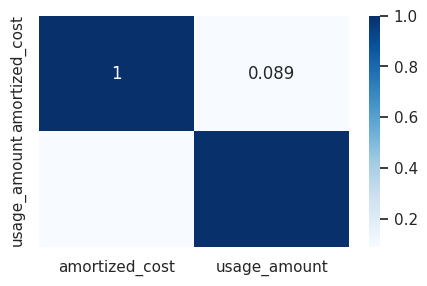

In [70]:
# using Pearson Correlation
df = data[data.columns]

plt.figure(figsize=(5,3))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

In [71]:
corr_matrix = data.select_dtypes(exclude=[np.object]).corr().abs()

# select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# find features with correlation > 0.95
columns_perfect_correlation = [column for column in upper.columns if any(upper[column] > 0.95)]
print("There are {} columns that are perfectly correlated with other columns: {} "\
          .format(len(columns_perfect_correlation), columns_perfect_correlation))

columns_perfect_correlation

There are 0 columns that are perfectly correlated with other columns: [] 


/tmp/ipykernel_3648/756641984.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  corr_matrix = data.select_dtypes(exclude=[np.object]).corr().abs()
/tmp/ipykernel_3648/756641984.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.select_dtypes(exclude=[np.object]).corr().abs()


[]

## Feature Engineering

- **Group categories from specific variable**

In [72]:
# environment_tag decoding
environment = {
    'None': 'none',
    'prod': 'production',
    'qa': 'quality',
    'dev': 'development',
    'uat': 'testing',
    'us-1': 'production',
    'dev01': 'development',
    'prod_us2': 'production',
    'prod_us3': 'production',
    'DEV': 'development',
    'default': 'other',
    'staging-1': 'development',
    'production': 'production',
    'qa01': 'quality',
    '¯\_(ツ)_/¯': 'other',
    'Corporate': 'other'
}

In [73]:
# group categories in environment_tag variable
data['environment_tag'] = data['environment_tag'].map(environment)

([<matplotlib.patches.Wedge at 0x7fd4397ef6a0>,
 [Text(-0.16350000656816085, 1.0877811121049177, 'none'),
  Text(-0.5206518889341619, -0.9689796749928707, 'production'),
  Text(0.6775014386355173, -0.8665978309728248, 'quality'),
  Text(1.0252336442979033, -0.39861757939112585, 'development'),
  Text(1.0922892620096853, -0.13001603015911856, 'testing'),
  Text(1.0999117944291452, -0.013929984768757443, 'other')],
 [Text(-0.08918182176445136, 0.5933351520572278, '54.75'),
  Text(-0.28399193941863377, -0.5285343681779294, '24.81'),
  Text(0.36954623925573665, -0.4726897259851771, '12.01'),
  Text(0.5592183514352199, -0.2174277705769777, '5.07'),
  Text(0.5957941429143738, -0.07091783463224648, '2.96'),
  Text(0.5999518878704428, -0.007598173510231332, '0.40')])

Text(0.5, 1.0, 'Environment (tag)')

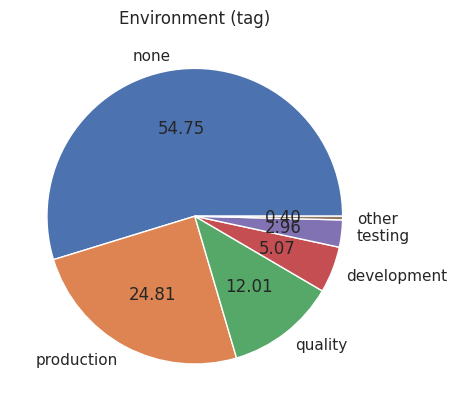

In [74]:
# plot a pie chart to visualize new environments
total = data['environment_tag'].value_counts().values.sum()

def fmt(x):
    return '{:.1f}%\n{:.0f}'.format(x, total*x/100)

plt.pie(data['environment_tag'].value_counts().values, labels=data['environment_tag'].value_counts().index, autopct='%.2f')
plt.title('Environment (tag)')
plt.show()

- **Create dummy variables**

In [75]:
# understand how Product(tag) is spread
data.product_tag.value_counts(normalize=True, dropna=False).mul(100).round(1).astype(str) + '%'

Product 5    49.2%
Product 6    24.7%
Product 4    16.2%
Product 3     3.4%
Product 1     3.4%
Product 7     2.1%
Product 8     0.8%
None          0.1%
Product 2     0.0%
Name: product_tag, dtype: object

In [76]:
# new product_type
product_type = pd.get_dummies(data['product_tag'])
product_type.rename(columns={"Product 1": "product_1", 
                             "Product 2": "product_2", 
                             "Product 3": "product_3",
                             "Product 4": "product_4",
                             "Product 5": "product_5",
                             "Product 6": "product_6",
                             "Product 7": "product_7",
                             "Product 8": "product_8",
                             "None": "product_none"
                            },inplace=True)
product_type.head()

product_1  product_2  product_3  product_4  product_5  product_6  \
0          0          0          0          0          1          0   
1          0          0          0          0          1          0   
2          0          0          0          0          1          0   
3          0          0          0          0          1          0   
4          0          0          0          0          1          0   

   product_7  product_8  product_none  
0          0          0             0  
1          0          0             0  
2          0          0             0  
3          0          0             0  
4          0          0             0

In [77]:
# new environment_type dummy
environment_type = pd.get_dummies(data['environment_tag'])
environment_type.rename(columns={"production": "env_production", "quality":"env_quality", "development":"env_development", "testing":"env_testing",
                                 "none":"env_none", "other":"env_other"},inplace=True)
environment_type.head()

env_development  env_none  env_other  env_production  env_quality  \
0                0         1          0               0            0   
1                0         1          0               0            0   
2                0         1          0               0            0   
3                0         1          0               0            0   
4                0         1          0               0            0   

   env_testing  
0            0  
1            0  
2            0  
3            0  
4            0

In [78]:
# new environment_product_type - I prefer more granularity in terms of service - FOCUS ON PRODUCTION, QUALITY AND DEVELOPMENT
# DO NOT USE TESTING FOR FIRST FORECASTING APPROACH, TESTING IS A TEMPORARY ENVIRONMENT
# Also, focus on PRODUCTS 1,4,5,6 (conclusions some chunks above)
data['environment_product_type'] = data[['product_tag', 'environment_tag']].agg('_'.join, axis=1)
environment_product_type = pd.get_dummies(data['environment_product_type'])

# remove columns that I won't use to forecast
environment_product_type = environment_product_type.drop(
    environment_product_type.filter(regex='none|other|Product 3|Product 2|Product 7|Product 8|testing').columns, axis=1)

# rename columns for better understanding
environment_product_type.rename(columns={"Product 1_development": "dev_product_1", 
                                         "Product 1_production":  "prod_product_1", 
                                         "Product 4_development": "dev_product_4",
                                         "Product 4_production":  "prod_product_4",
                                         "Product 4_quality":     "qa_product_4",
                                         "Product 5_development": "dev_product_5",
                                         "Product 5_production":  "prod_product_5",
                                         "Product 5_quality":     "qa_product_5",
                                         "Product 6_development": "dev_product_6",
                                         "Product 6_production":  "prod_product_6",
                                         "Product 6_quality":     "qa_product_6"
                                        },inplace=True)
environment_product_type.head()

dev_product_1  prod_product_1  dev_product_4  prod_product_4  qa_product_4  \
0              0               0              0               0             0   
1              0               0              0               0             0   
2              0               0              0               0             0   
3              0               0              0               0             0   
4              0               0              0               0             0   

   dev_product_5  prod_product_5  qa_product_5  dev_product_6  prod_product_6  \
0              0               0             0              0               0   
1              0               0             0              0               0   
2              0               0             0              0               0   
3              0               0             0              0               0   
4              0               0             0              0               0   

   qa_product_6  
0             0  
1             0  
2             0  
3             0  
4             0

In [79]:
# concatenate new dummy variables to dataframe
data_dummy = pd.concat([data, environment_product_type], axis = 1)

# drop previous columns
data_dummy.drop(columns=["environment_tag", "product_tag", "environment_product_type"], axis=1, inplace =True)
data_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1719914 entries, 0 to 1719913
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   usage_date             datetime64[ns]
 1   line_item_type         category      
 2   product_code           category      
 3   line_item_description  object        
 4   usage_type             category      
 5   usage_type_aws         object        
 6   operation              object        
 7   amortized_cost         float64       
 8   usage_amount           float64       
 9   dev_product_1          uint8         
 10  prod_product_1         uint8         
 11  dev_product_4          uint8         
 12  prod_product_4         uint8         
 13  qa_product_4           uint8         
 14  dev_product_5          uint8         
 15  prod_product_5         uint8         
 16  qa_product_5           uint8         
 17  dev_product_6          uint8         
 18  prod_product_6        

## Preprocessing

In [80]:
# drop non needed columns
data_to_forecast = data_dummy.copy()
data_to_forecast.drop(columns=["line_item_type", "product_code", "line_item_description", "usage_type",
                                            "usage_type_aws", "operation"], axis=1, inplace =True)

data_to_forecast.head()

usage_date  amortized_cost  usage_amount  dev_product_1  prod_product_1  \
0 2021-10-10            2.46        245.99              0               0   
1 2021-10-11            1.51         50.46              0               0   
2 2021-10-12            0.00        620.00              0               0   
3 2021-10-25            0.19         23.41              0               0   
4 2021-10-02            0.00          1.00              0               0   

   dev_product_4  prod_product_4  qa_product_4  dev_product_5  prod_product_5  \
0              0               0             0              0               0   
1              0               0             0              0               0   
2              0               0             0              0               0   
3              0               0             0              0               0   
4              0               0             0              0               0   

   qa_product_5  dev_product_6  prod_product_6  qa_product_6  
0             0              0               0             0  
1             0              0               0             0  
2             0              0               0             0  
3             0              0               0             0  
4             0              0               0             0

In [81]:
# select columns with word 'product'
prod_cols = data_to_forecast.filter(like='product').columns

# alocate amortized cost to each product before grouping
data_to_forecast[prod_cols] = data_to_forecast[prod_cols].multiply(data_to_forecast["amortized_cost"], axis="index")

# check above computation with example
#output = data_to_forecast[data_to_forecast['prod_product_5'] != 0]

In [82]:
# group data by usage_date
data_to_forecast = data_to_forecast.groupby('usage_date').agg({'amortized_cost': 'sum', 'usage_amount': 'sum', 
                         'dev_product_1': 'sum',
                         'prod_product_1': 'sum', 
                         'dev_product_4': 'sum', 
                         'prod_product_4': 'sum', 
                         'qa_product_4': 'sum',
                         'dev_product_5': 'sum', 
                         'prod_product_5': 'sum', 
                         'qa_product_5': 'sum', 
                         'dev_product_6': 'sum',
                         'prod_product_6': 'sum',
                         'qa_product_6': 'sum'
                        }).reset_index()
data_to_forecast.head()
data_to_forecast.shape
#data_to_forecast

usage_date  amortized_cost  usage_amount  dev_product_1  prod_product_1  \
0 2021-10-01        11888.45  112687473.01           0.00            0.00   
1 2021-10-02         3442.42   96255069.38           0.00            0.00   
2 2021-10-03         3472.92   98174566.06           0.00            0.00   
3 2021-10-04         3591.56  118810061.96           0.00            0.00   
4 2021-10-05         3620.85  117422224.36           0.00            0.00   

   dev_product_4  prod_product_4  qa_product_4  dev_product_5  prod_product_5  \
0           0.00            0.00          0.00           0.00           72.12   
1           0.00            0.00          0.00           0.00            1.75   
2           0.00            0.00          0.00           0.00           10.51   
3           0.00            0.00          0.00           0.00           36.56   
4           0.00            0.00          0.00           0.00           24.49   

   qa_product_5  dev_product_6  prod_product_6  qa_product_6  
0          0.00           0.00            0.00          0.00  
1          0.00           0.00            0.00          0.00  
2          0.00           0.00            0.00          0.00  
3          0.00           0.00            0.00          0.00  
4          0.00           0.00            0.00          0.00

(547, 14)

In [83]:
# Unit test - check if any duplicates
num_duplicate_rows = data_to_forecast['usage_date'].duplicated().sum()
print("Number of duplicate rows: ", num_duplicate_rows)

Number of duplicate rows:  0


### Environment and Product Segmentation

In [84]:
# create different dataframes due to forecasting reasons - later code optimization with function!
dev_product_1 = data_to_forecast[["usage_date", "dev_product_1"]]
prod_product_1 = data_to_forecast[["usage_date", "prod_product_1"]]

dev_product_4 = data_to_forecast[["usage_date", "dev_product_4"]]
prod_product_4 = data_to_forecast[["usage_date", "prod_product_4"]]
qa_product_4 = data_to_forecast[["usage_date", "qa_product_4"]]

dev_product_5 = data_to_forecast[["usage_date", "dev_product_5"]]
prod_product_5 = data_to_forecast[["usage_date", "prod_product_5"]]
qa_product_5 = data_to_forecast[["usage_date", "qa_product_5"]]

dev_product_6 = data_to_forecast[["usage_date", "dev_product_6"]]
prod_product_6 = data_to_forecast[["usage_date", "prod_product_6"]]
qa_product_6 = data_to_forecast[["usage_date", "qa_product_6"]]

In [85]:
#dev_product_1.head()

- **Visualize the behaviour of all products in Production**

<Figure size 2500x1000 with 0 Axes>

Text(0.5, 1.0, 'Products in Production Environment by Date')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Products')

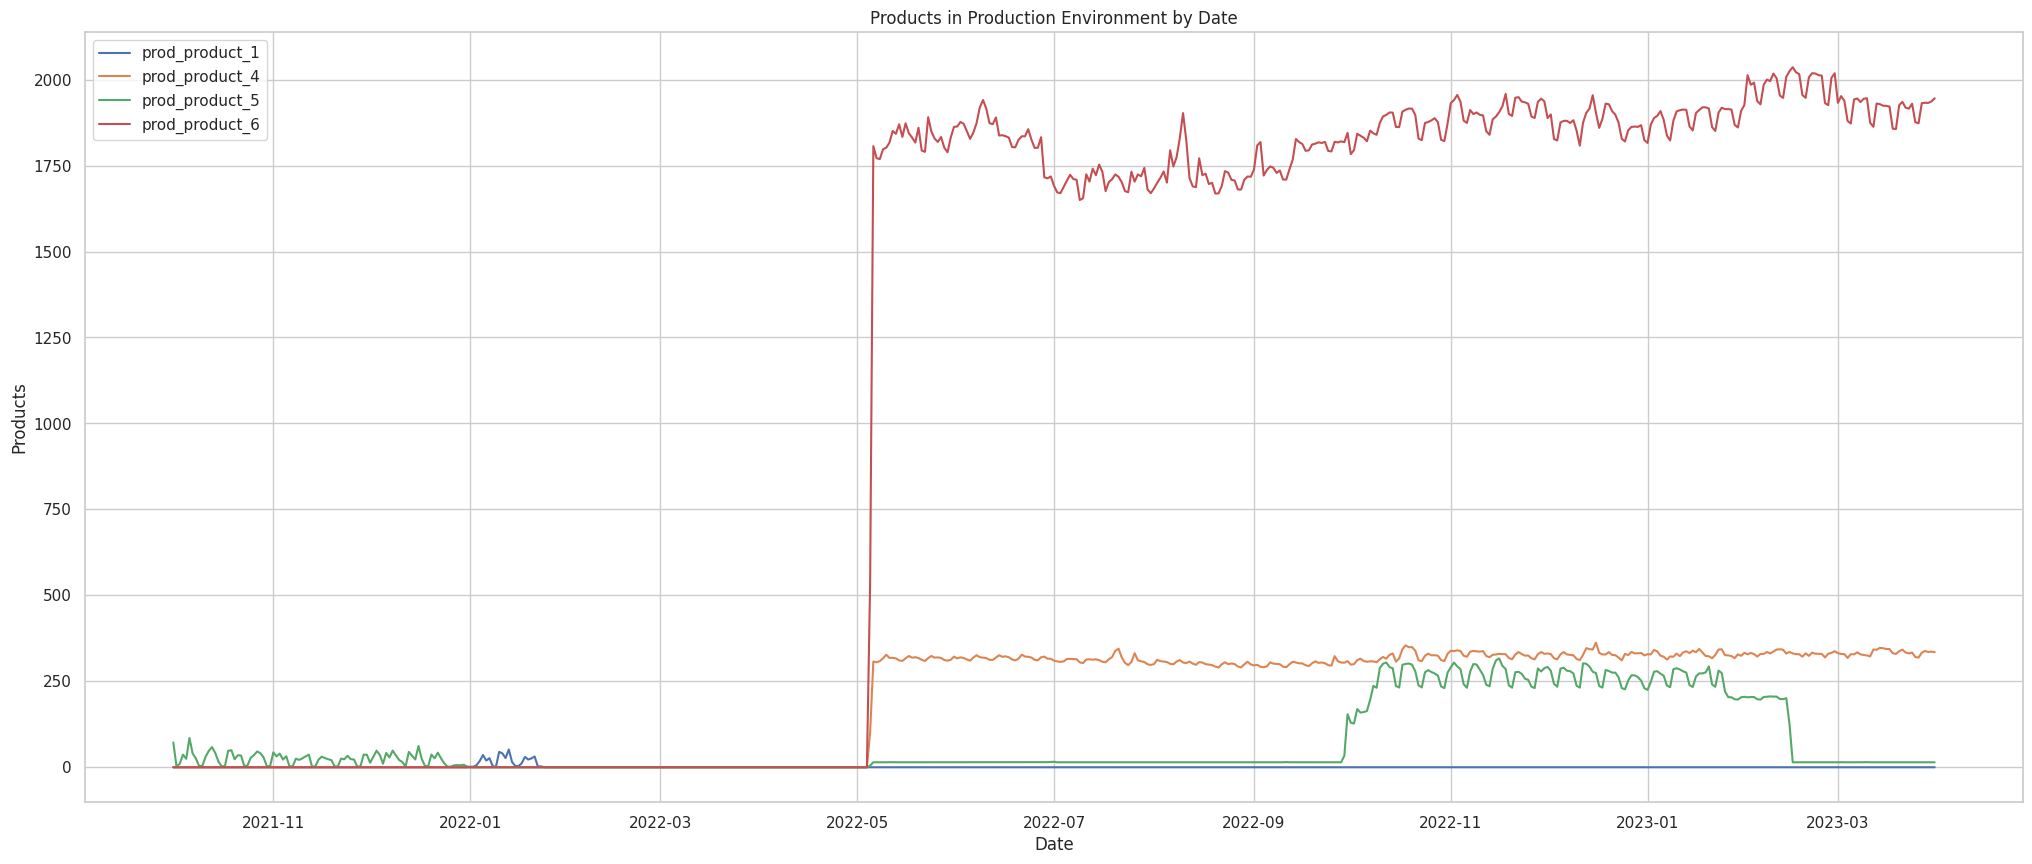

In [86]:
# Plotting the time series of given dataframe
plt.figure(figsize=(25,10))
plt.plot(prod_product_1.usage_date, prod_product_1.prod_product_1, label = 'prod_product_1')
plt.plot(prod_product_4.usage_date, prod_product_4.prod_product_4, label = 'prod_product_4')
plt.plot(prod_product_5.usage_date, prod_product_5.prod_product_5, label = 'prod_product_5')
plt.plot(prod_product_6.usage_date, prod_product_6.prod_product_6, label = 'prod_product_6')
 
# Giving title to the chart using plt.title
plt.title('Products in Production Environment by Date')
 
# Providing x and y label to the chart
plt.xlabel('Date')
plt.ylabel('Products')

plt.legend() 
plt.show()

- **Visualize the behaviour of all products in Development**

<Figure size 2500x1000 with 0 Axes>

Text(0.5, 1.0, 'Products in Development Environment by Date')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Products')

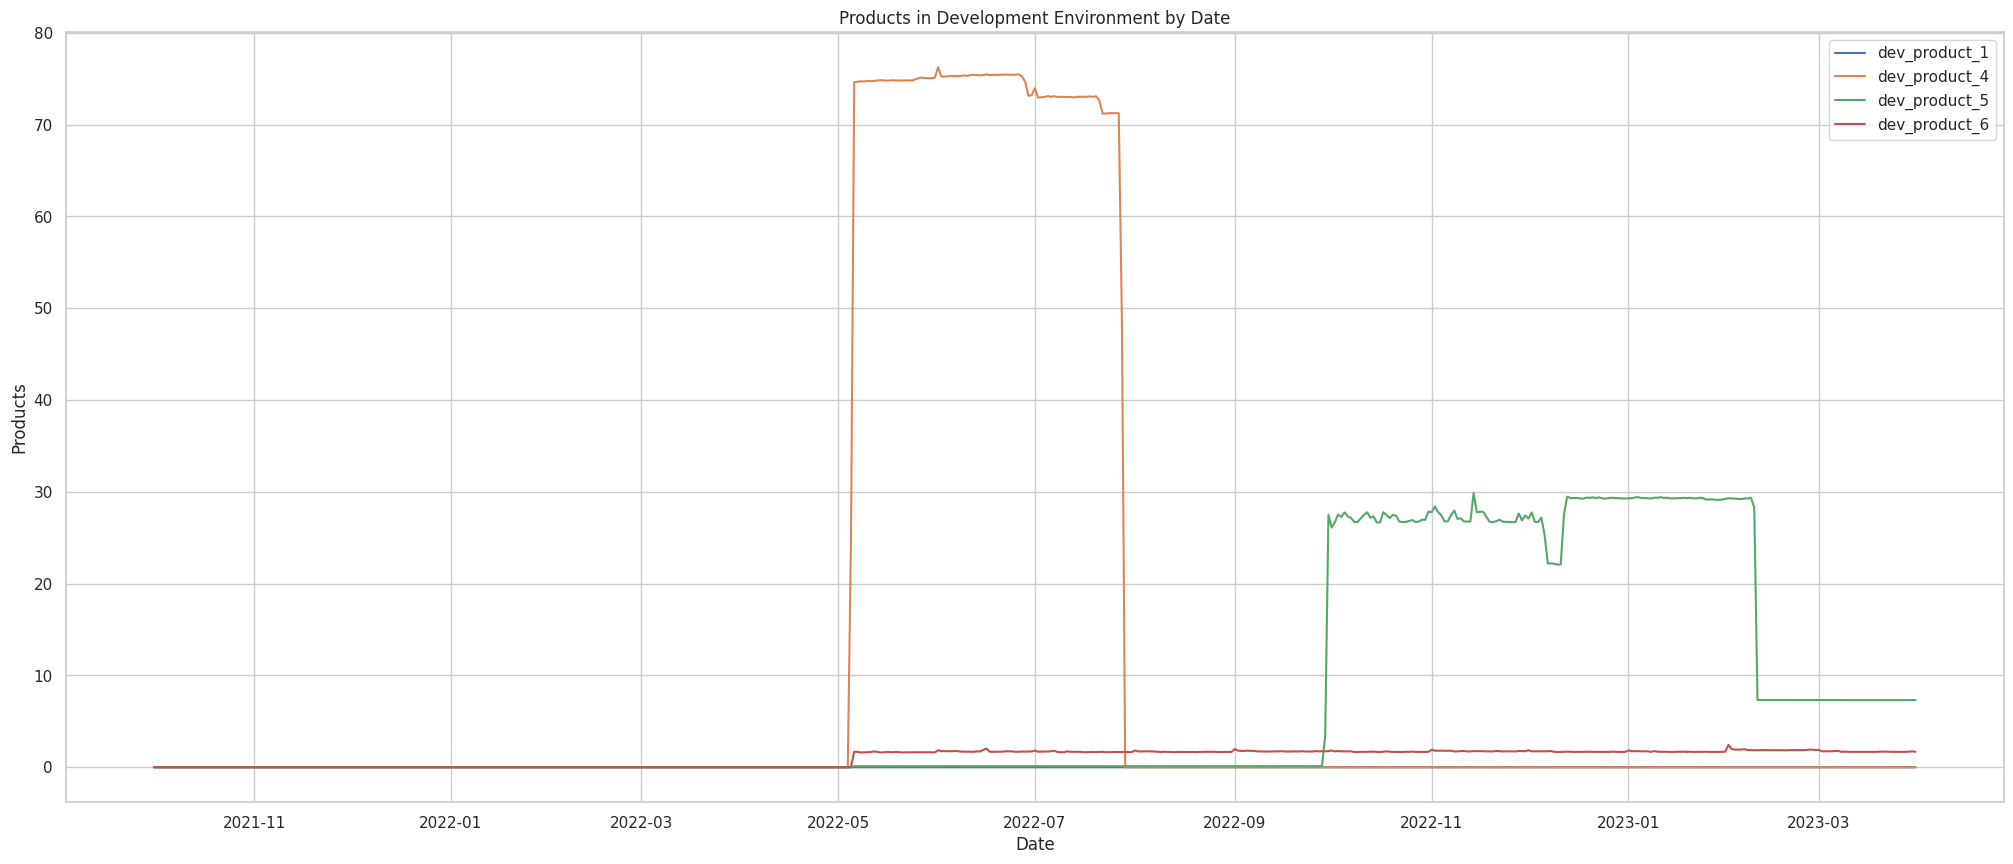

In [87]:
# Plotting the time series of given dataframe
plt.figure(figsize=(25,10))
plt.plot(dev_product_1.usage_date, dev_product_1.dev_product_1, label = 'dev_product_1')
plt.plot(dev_product_4.usage_date, dev_product_4.dev_product_4, label = 'dev_product_4')
plt.plot(dev_product_5.usage_date, dev_product_5.dev_product_5, label = 'dev_product_5')
plt.plot(dev_product_6.usage_date, dev_product_6.dev_product_6, label = 'dev_product_6')
 
# Giving title to the chart using plt.title
plt.title('Products in Development Environment by Date')
 
# Providing x and y label to the chart
plt.xlabel('Date')
plt.ylabel('Products')

plt.legend() 
plt.show()

- **Visualize the behaviour of all products in Quality**

<Figure size 2500x1000 with 0 Axes>

Text(0.5, 1.0, 'Products in Quality Environment by Date')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Products')

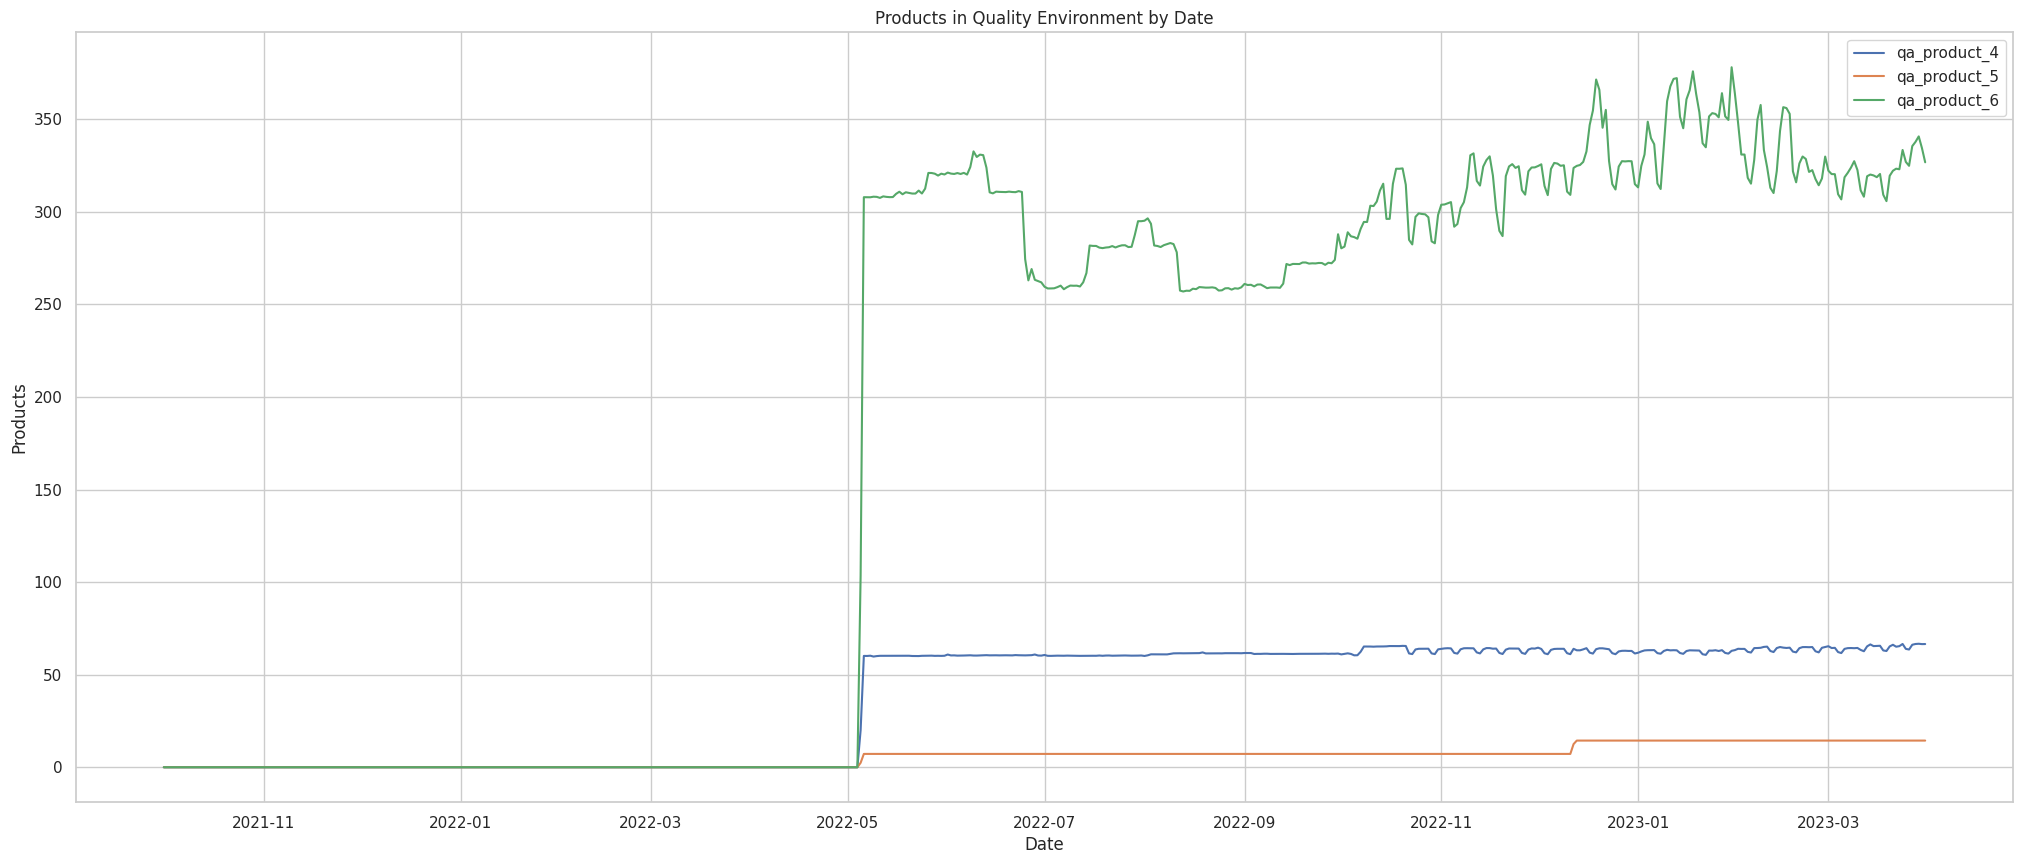

In [88]:
# Plotting the time series of given dataframe
plt.figure(figsize=(25,10))
plt.plot(qa_product_4.usage_date, qa_product_4.qa_product_4, label = 'qa_product_4')
plt.plot(qa_product_5.usage_date, qa_product_5.qa_product_5, label = 'qa_product_5')
plt.plot(qa_product_6.usage_date, qa_product_6.qa_product_6, label = 'qa_product_6')
 
# Giving title to the chart using plt.title
plt.title('Products in Quality Environment by Date')
 
# Providing x and y label to the chart
plt.xlabel('Date')
plt.ylabel('Products')

plt.legend() 
plt.show()

**Observations from line graphs:** \
    - on May 2022 there was a significant increase of usage of the products 4 and 6 \
    - in Production and Quality environment, product 6 shows higher costs \
    - in Development, product 4 shows higher costs \
    - in Quality, products 5 and 6 shows more stability regarding amortized cost

In [89]:
# rename all columns into Prophet desired format - create optimized function
dfs = [dev_product_1,
       prod_product_1,
       dev_product_4, 
       prod_product_4,
       qa_product_4,
       dev_product_5,
       prod_product_5,
       qa_product_5,
       dev_product_6,
       prod_product_6,
       qa_product_6]

for df in dfs:
    df.columns = ['ds', 'y']

In [90]:
#dev_product_1.head()
dev_product_1.columns
dev_product_1.dtypes

Index(['ds', 'y'], dtype='object')

ds    datetime64[ns]
y            float64
dtype: object

______________________________________________________________________

# Forecast

In [91]:
# forecasting using prophet library, function that returns the forecasting of future and plots
def fit_predict_model(dataframe, period, interval_width = 0.99):
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'multiplicative', 
                interval_width = interval_width)
    m = m.fit(dataframe)
    future_cost = m.make_future_dataframe(periods=period)
    forecasts = m.predict(future_cost)
    forecast = forecasts[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

    # plot the forecasts
    fig = m.plot(forecasts)
    a = add_changepoints_to_plot(fig.gca(), m, forecasts)

    # plot the components 
    fig2 = m.plot_components(forecasts)

    # merging two dataset to have the actual and prediction values
    forecasting_final = pd.merge(forecast, dataframe, how ='inner',
                                     left_on = 'ds', right_on = 'ds')

    # calculate the prediction error here and uncertainty
    forecasting_final['error'] = forecasting_final['y'] - forecasting_final['yhat']
    forecasting_final['uncertainty'] = forecasting_final['yhat_upper'] - forecasting_final['yhat_lower']

    # identify the outlier or anomaly - this factor can be customized based on the data
    factor = 1.5
    forecasting_final['anomaly'] = forecasting_final.apply(lambda x: 'Yes' 
          if(np.abs(x['error']) > factor*x['uncertainty']) else 'No', axis = 1)

    # plot anomalies
    color_discrete_map = {'Yes': 'rgb(255,12,0)', 'No': 'blue'}
    fig = px.scatter(forecasting_final, x='ds', y='y', color='anomaly', title='Anomaly',
                 color_discrete_map=color_discrete_map)
    fig.show()
    
    # Mean Absolute Error (MAE)
    MAE = mean_absolute_error(forecasting_final['yhat'],forecasting_final['y'])
    print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

    # Median Absolute Error (MedAE)
    MEDAE = median_absolute_error(forecasting_final['yhat'],forecasting_final['y'])
    print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

    # Mean Squared Error (MSE)
    MSE = mean_squared_error(forecasting_final['yhat'],forecasting_final['y'])
    print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

    # Root Mean Squarred Error (RMSE) 
    RMSE = sqrt(int(mean_squared_error(forecasting_final['yhat'],forecasting_final['y'])))
    print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

    # Mean Absolute Percentage Error (MAPE)
    MAPE = mean_absolute_percentage_error(forecasting_final['yhat'],forecasting_final['y'])
    print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

    return forecasts

**Detecting Anomalies:**
- The light blue boundaries will be yhat_upper and yhat_lower
- If y value is greater than yhat_upper and less than yhat lower then it is an anomaly
- Also getting the importance of that anomaly based on its distance from yhat_upper and yhat_lower

#### Product 1

*Defining period = **180 days** (6 months of forecast)*

23:33:58.019 - DEBUG : input tempfile: /tmp/tmpetdz23jt/bc1b5n5z.json
23:33:58.023 - DEBUG : input tempfile: /tmp/tmpetdz23jt/efdcu2z4.json
23:33:58.024 - DEBUG : idx 0
23:33:58.025 - DEBUG : running CmdStan, num_threads: None
23:33:58.025 - DEBUG : CmdStan args: ['/mnt/N0326018/.venv/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25234', 'data', 'file=/tmp/tmpetdz23jt/bc1b5n5z.json', 'init=/tmp/tmpetdz23jt/efdcu2z4.json', 'output', 'file=/tmp/tmpetdz23jt/prophet_modelh35tmuyb/prophet_model-20231010233358.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:58 - cmdstanpy - INFO - Chain [1] start processing
23:33:58.025 - INFO : Chain [1] start processing
23:33:58 - cmdstanpy - INFO - Chain [1] done processing
23:33:58.071 - INFO : Chain [1] done processing


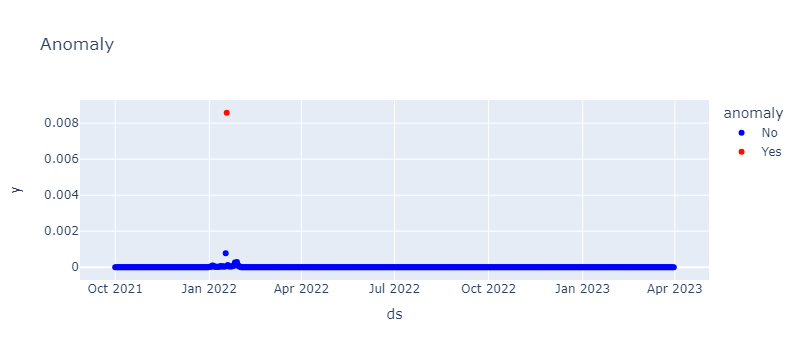

Mean Absolute Error (MAE): 0.0
Median Absolute Error (MedAE): 0.0
Mean Squared Error (MSE): 0.0
Root Mean Squared Error (RMSE): 0.0
Mean Absolute Percentage Error (MAPE): 1.3 %


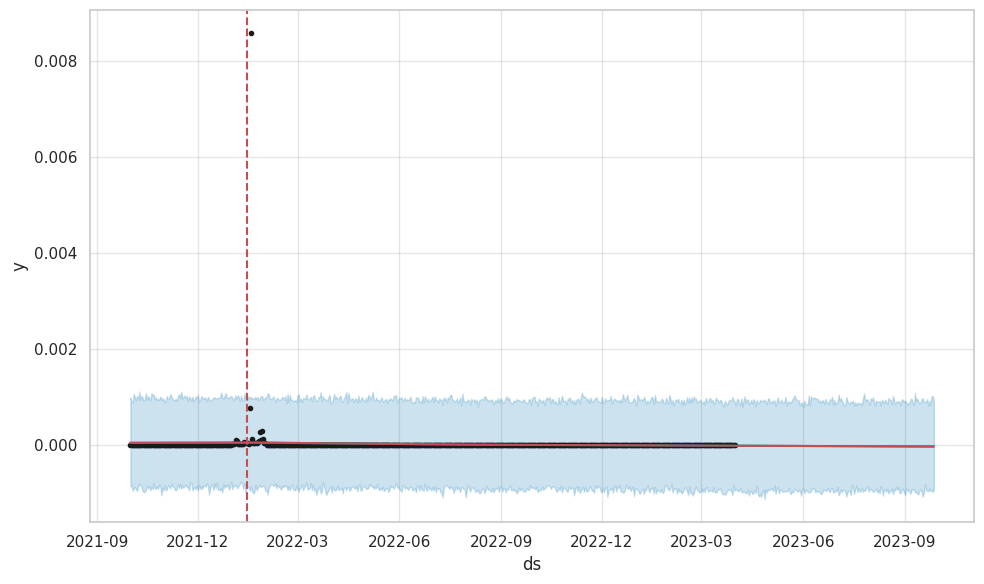

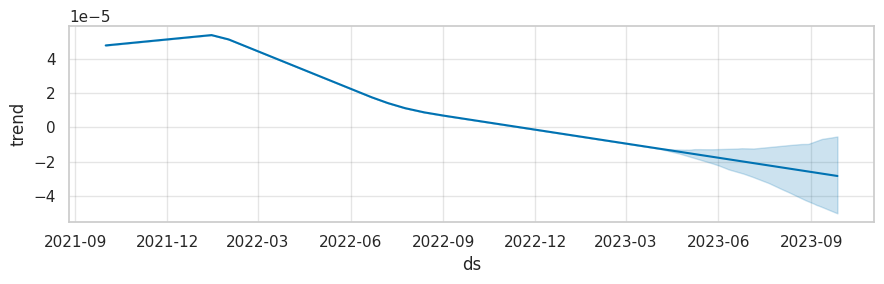

In [92]:
pred_d1 = fit_predict_model(dev_product_1, 180)

23:33:59.712 - DEBUG : input tempfile: /tmp/tmpetdz23jt/8hfzp_me.json
23:33:59.716 - DEBUG : input tempfile: /tmp/tmpetdz23jt/hwwgdlop.json
23:33:59.717 - DEBUG : idx 0
23:33:59.717 - DEBUG : running CmdStan, num_threads: None
23:33:59.718 - DEBUG : CmdStan args: ['/mnt/N0326018/.venv/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29086', 'data', 'file=/tmp/tmpetdz23jt/8hfzp_me.json', 'init=/tmp/tmpetdz23jt/hwwgdlop.json', 'output', 'file=/tmp/tmpetdz23jt/prophet_modeljgwktqc5/prophet_model-20231010233359.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:33:59 - cmdstanpy - INFO - Chain [1] start processing
23:33:59.718 - INFO : Chain [1] start processing
23:33:59 - cmdstanpy - INFO - Chain [1] done processing
23:33:59.746 - INFO : Chain [1] done processing


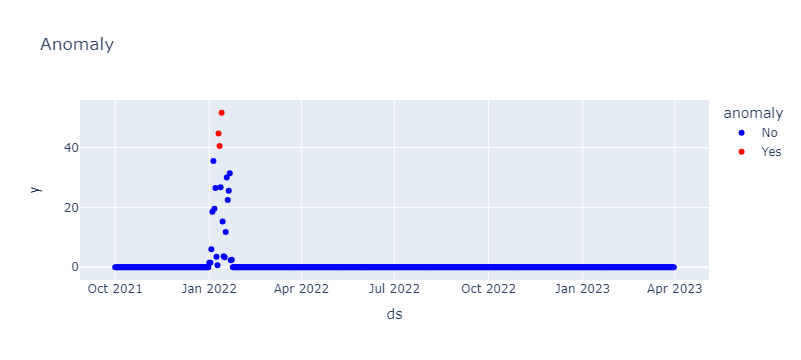

Mean Absolute Error (MAE): 1.4
Median Absolute Error (MedAE): 0.11
Mean Squared Error (MSE): 20.98
Root Mean Squared Error (RMSE): 4.47
Mean Absolute Percentage Error (MAPE): 1.16 %


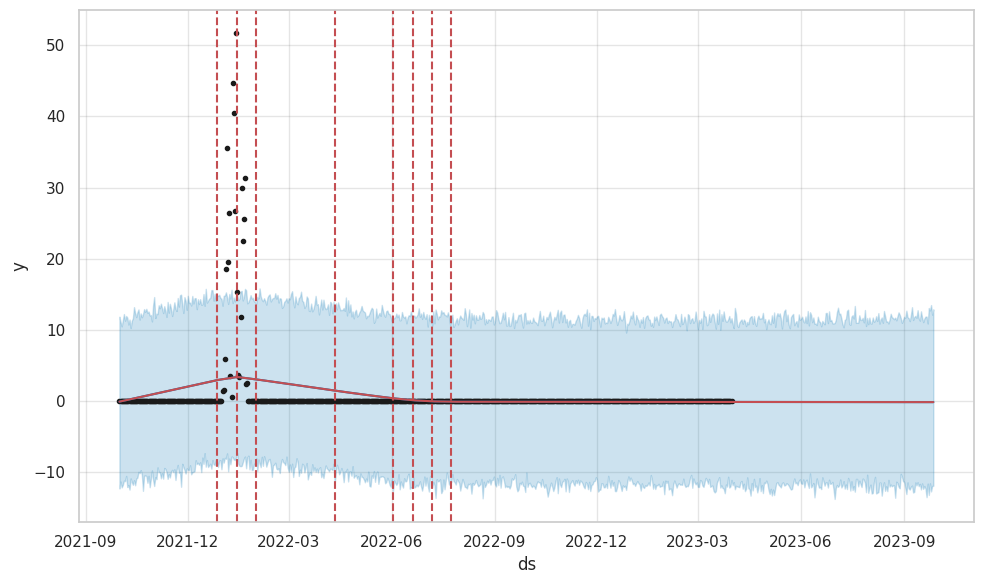

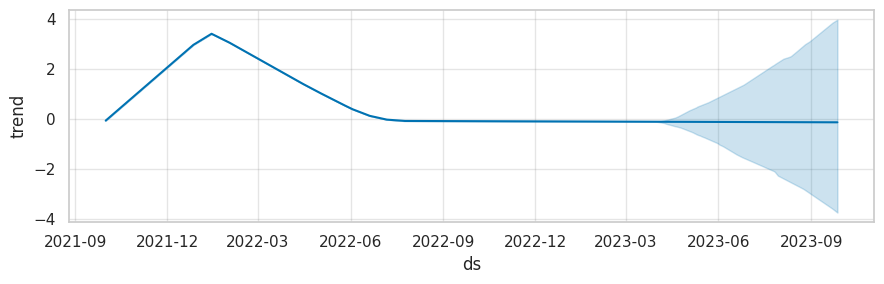

In [93]:
pred_p1 = fit_predict_model(prod_product_1, 180)

#### Product 4

23:34:00.730 - DEBUG : input tempfile: /tmp/tmpetdz23jt/9zb8mra3.json
23:34:00.734 - DEBUG : input tempfile: /tmp/tmpetdz23jt/wqdln1sk.json
23:34:00.735 - DEBUG : idx 0
23:34:00.735 - DEBUG : running CmdStan, num_threads: None
23:34:00.736 - DEBUG : CmdStan args: ['/mnt/N0326018/.venv/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76886', 'data', 'file=/tmp/tmpetdz23jt/9zb8mra3.json', 'init=/tmp/tmpetdz23jt/wqdln1sk.json', 'output', 'file=/tmp/tmpetdz23jt/prophet_model2mtuxd14/prophet_model-20231010233400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:34:00 - cmdstanpy - INFO - Chain [1] start processing
23:34:00.736 - INFO : Chain [1] start processing
23:34:00 - cmdstanpy - INFO - Chain [1] done processing
23:34:00.802 - INFO : Chain [1] done processing


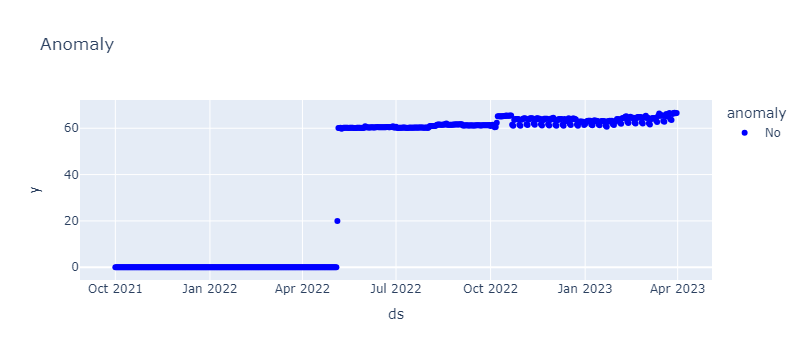

Mean Absolute Error (MAE): 3.7
Median Absolute Error (MedAE): 1.07
Mean Squared Error (MSE): 56.05
Root Mean Squared Error (RMSE): 7.48
Mean Absolute Percentage Error (MAPE): 0.44 %


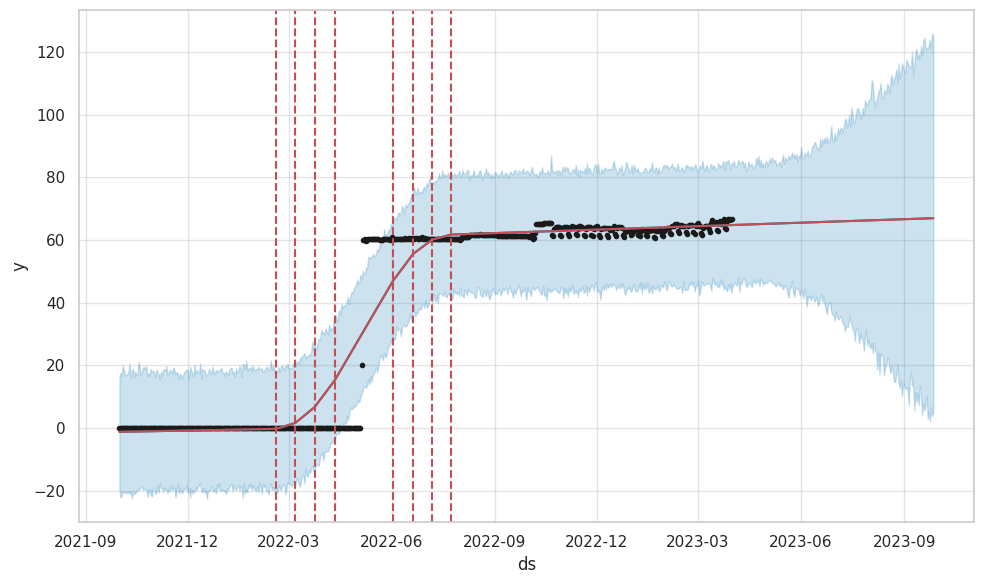

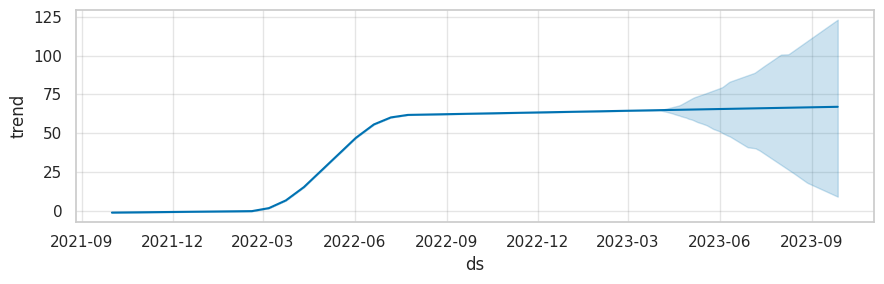

In [94]:
pred_q4 = fit_predict_model(qa_product_4, 180)

23:34:01.643 - DEBUG : input tempfile: /tmp/tmpetdz23jt/jajc4_yg.json
23:34:01.646 - DEBUG : input tempfile: /tmp/tmpetdz23jt/ua2v7yel.json
23:34:01.647 - DEBUG : idx 0
23:34:01.648 - DEBUG : running CmdStan, num_threads: None
23:34:01.648 - DEBUG : CmdStan args: ['/mnt/N0326018/.venv/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63206', 'data', 'file=/tmp/tmpetdz23jt/jajc4_yg.json', 'init=/tmp/tmpetdz23jt/ua2v7yel.json', 'output', 'file=/tmp/tmpetdz23jt/prophet_modelscvn2az5/prophet_model-20231010233401.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:34:01 - cmdstanpy - INFO - Chain [1] start processing
23:34:01.648 - INFO : Chain [1] start processing
23:34:01 - cmdstanpy - INFO - Chain [1] done processing
23:34:01.690 - INFO : Chain [1] done processing


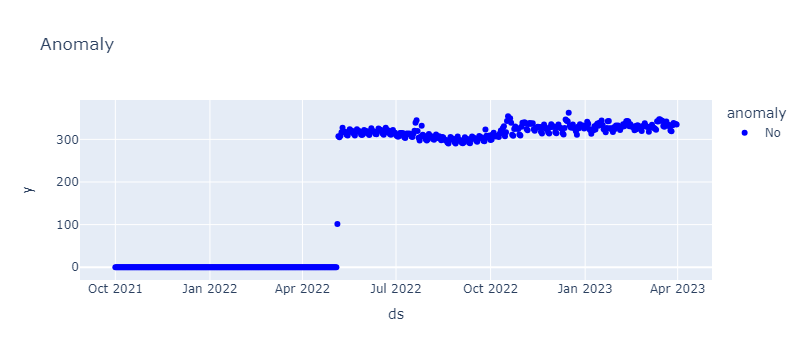

Mean Absolute Error (MAE): 21.86
Median Absolute Error (MedAE): 6.83
Mean Squared Error (MSE): 1661.58
Root Mean Squared Error (RMSE): 40.76
Mean Absolute Percentage Error (MAPE): 0.45 %


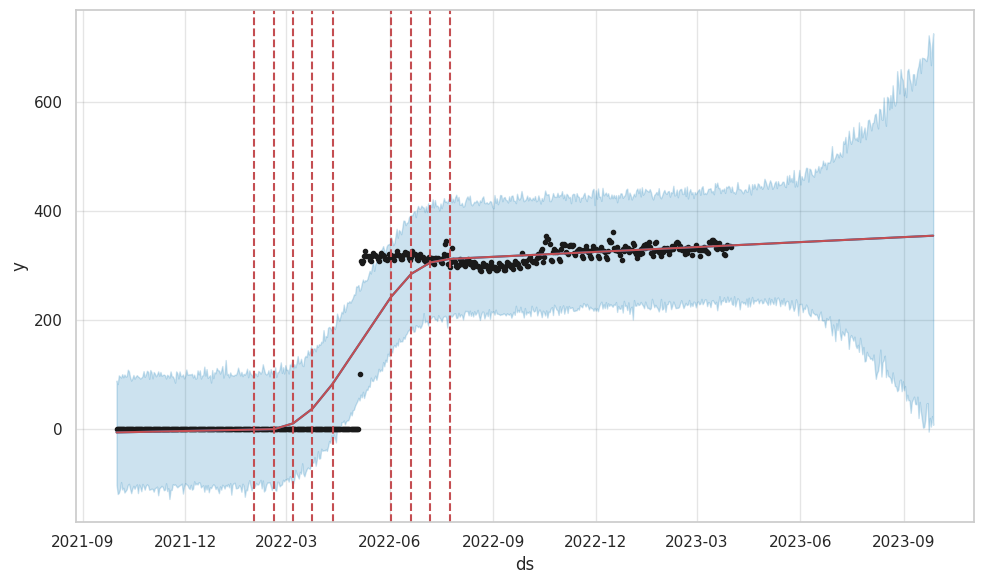

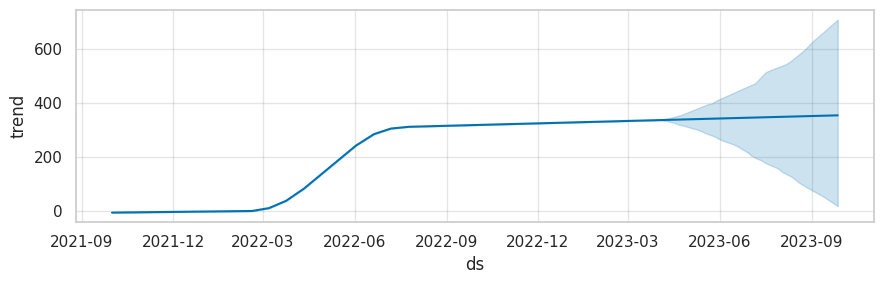

In [95]:
pred_p4 = fit_predict_model(prod_product_4, 180)

#### Product 5

23:34:02.505 - DEBUG : input tempfile: /tmp/tmpetdz23jt/o9op_py0.json
23:34:02.509 - DEBUG : input tempfile: /tmp/tmpetdz23jt/v_d5xur7.json
23:34:02.510 - DEBUG : idx 0
23:34:02.510 - DEBUG : running CmdStan, num_threads: None
23:34:02.510 - DEBUG : CmdStan args: ['/mnt/N0326018/.venv/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97525', 'data', 'file=/tmp/tmpetdz23jt/o9op_py0.json', 'init=/tmp/tmpetdz23jt/v_d5xur7.json', 'output', 'file=/tmp/tmpetdz23jt/prophet_model5inxxppg/prophet_model-20231010233402.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:34:02 - cmdstanpy - INFO - Chain [1] start processing
23:34:02.511 - INFO : Chain [1] start processing
23:34:02 - cmdstanpy - INFO - Chain [1] done processing
23:34:02.550 - INFO : Chain [1] done processing


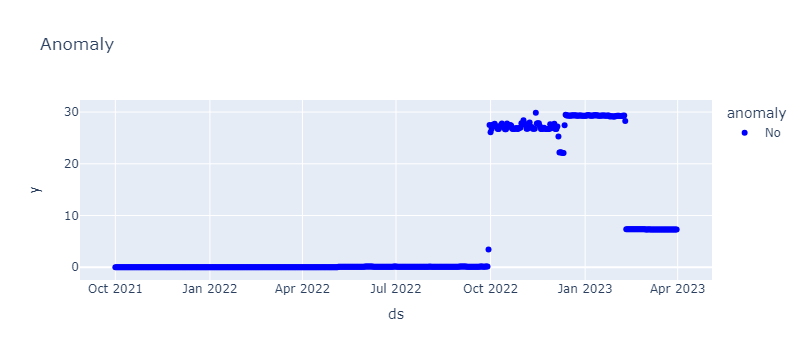

Mean Absolute Error (MAE): 3.14
Median Absolute Error (MedAE): 0.51
Mean Squared Error (MSE): 24.64
Root Mean Squared Error (RMSE): 4.9
Mean Absolute Percentage Error (MAPE): 0.88 %


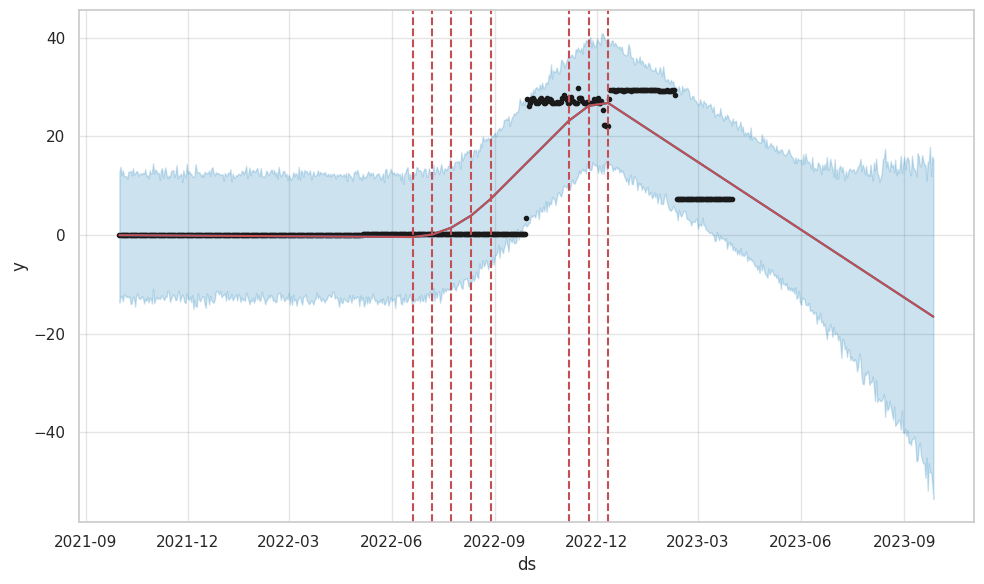

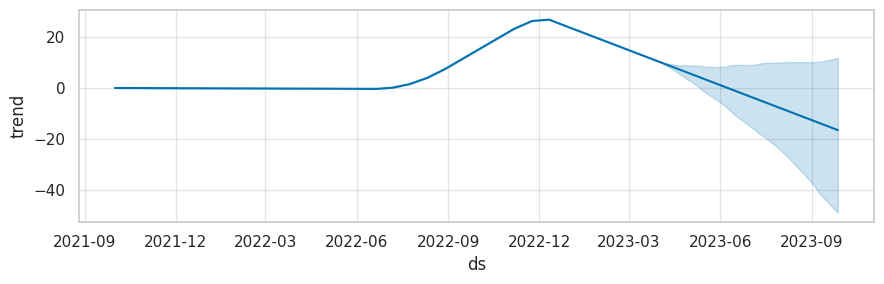

In [96]:
pred_d5 = fit_predict_model(dev_product_5, 180)

23:34:03.372 - DEBUG : input tempfile: /tmp/tmpetdz23jt/drrh9tna.json
23:34:03.376 - DEBUG : input tempfile: /tmp/tmpetdz23jt/10066wbw.json
23:34:03.377 - DEBUG : idx 0
23:34:03.378 - DEBUG : running CmdStan, num_threads: None
23:34:03.378 - DEBUG : CmdStan args: ['/mnt/N0326018/.venv/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76342', 'data', 'file=/tmp/tmpetdz23jt/drrh9tna.json', 'init=/tmp/tmpetdz23jt/10066wbw.json', 'output', 'file=/tmp/tmpetdz23jt/prophet_model2l7z7jgd/prophet_model-20231010233403.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:34:03 - cmdstanpy - INFO - Chain [1] start processing
23:34:03.379 - INFO : Chain [1] start processing
23:34:03 - cmdstanpy - INFO - Chain [1] done processing
23:34:03.413 - INFO : Chain [1] done processing


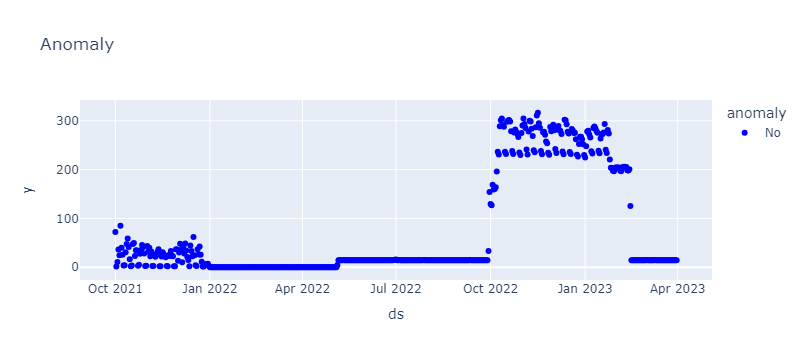

Mean Absolute Error (MAE): 26.68
Median Absolute Error (MedAE): 11.84
Mean Squared Error (MSE): 1575.75
Root Mean Squared Error (RMSE): 39.69
Mean Absolute Percentage Error (MAPE): 0.7 %


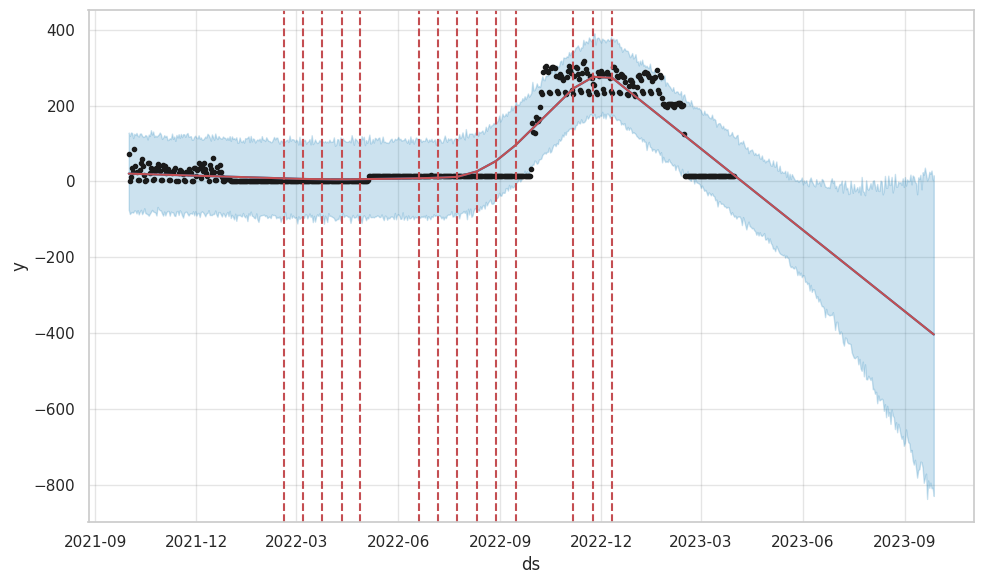

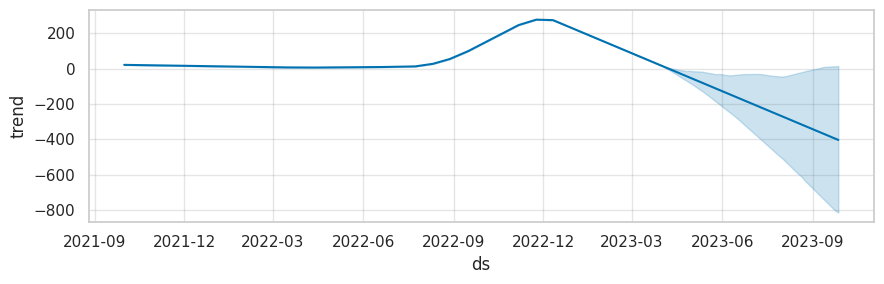

In [97]:
pred_p5 = fit_predict_model(prod_product_5, 180)

23:34:04.238 - DEBUG : input tempfile: /tmp/tmpetdz23jt/av_7wz35.json
23:34:04.242 - DEBUG : input tempfile: /tmp/tmpetdz23jt/l3j1g6n2.json
23:34:04.243 - DEBUG : idx 0
23:34:04.243 - DEBUG : running CmdStan, num_threads: None
23:34:04.244 - DEBUG : CmdStan args: ['/mnt/N0326018/.venv/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90496', 'data', 'file=/tmp/tmpetdz23jt/av_7wz35.json', 'init=/tmp/tmpetdz23jt/l3j1g6n2.json', 'output', 'file=/tmp/tmpetdz23jt/prophet_modelf89niixk/prophet_model-20231010233404.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:34:04 - cmdstanpy - INFO - Chain [1] start processing
23:34:04.244 - INFO : Chain [1] start processing
23:34:04 - cmdstanpy - INFO - Chain [1] done processing
23:34:04.294 - INFO : Chain [1] done processing


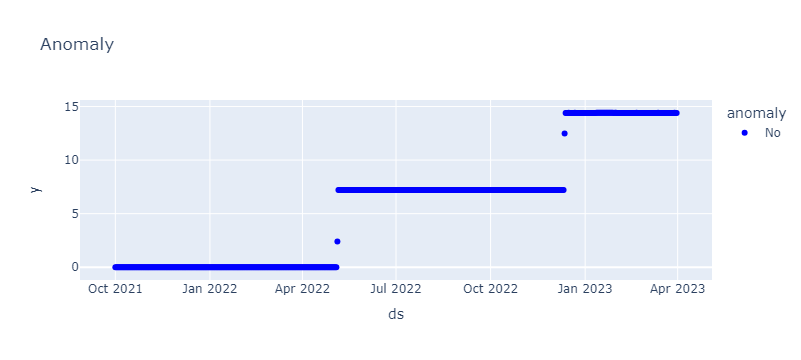

Mean Absolute Error (MAE): 1.08
Median Absolute Error (MedAE): 0.71
Mean Squared Error (MSE): 2.26
Root Mean Squared Error (RMSE): 1.41
Mean Absolute Percentage Error (MAPE): 0.5 %


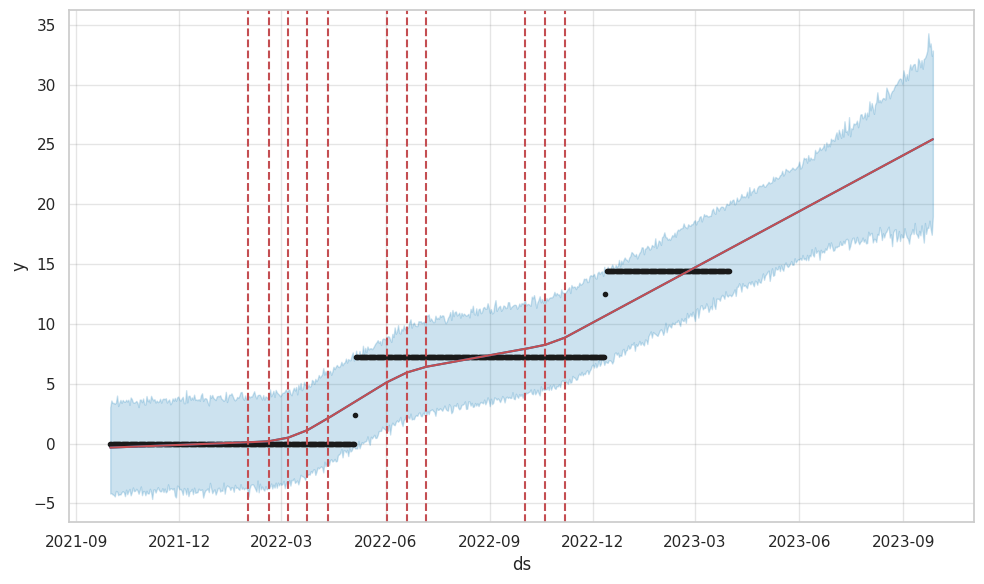

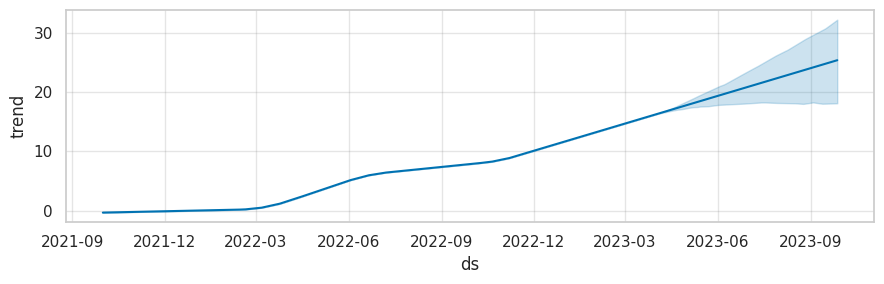

In [98]:
pred_q5 = fit_predict_model(qa_product_5, 180)

#### Product 6

23:34:05.129 - DEBUG : input tempfile: /tmp/tmpetdz23jt/5cyfgai9.json
23:34:05.133 - DEBUG : input tempfile: /tmp/tmpetdz23jt/oia_echx.json
23:34:05.134 - DEBUG : idx 0
23:34:05.134 - DEBUG : running CmdStan, num_threads: None
23:34:05.134 - DEBUG : CmdStan args: ['/mnt/N0326018/.venv/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86139', 'data', 'file=/tmp/tmpetdz23jt/5cyfgai9.json', 'init=/tmp/tmpetdz23jt/oia_echx.json', 'output', 'file=/tmp/tmpetdz23jt/prophet_modelaqg81na8/prophet_model-20231010233405.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:34:05 - cmdstanpy - INFO - Chain [1] start processing
23:34:05.135 - INFO : Chain [1] start processing
23:34:05 - cmdstanpy - INFO - Chain [1] done processing
23:34:05.181 - INFO : Chain [1] done processing


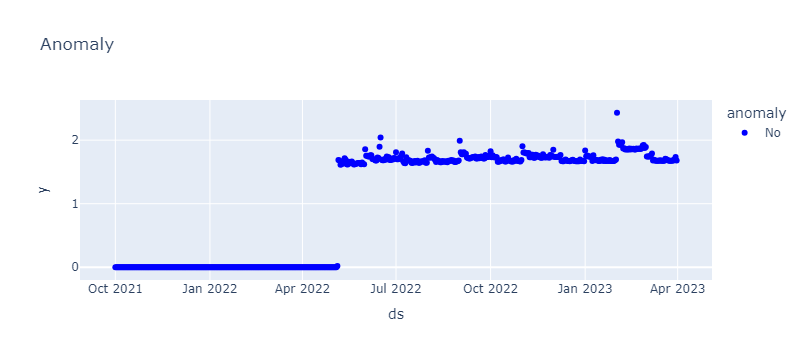

Mean Absolute Error (MAE): 0.11
Median Absolute Error (MedAE): 0.05
Mean Squared Error (MSE): 0.04
Root Mean Squared Error (RMSE): 0.0
Mean Absolute Percentage Error (MAPE): 0.44 %


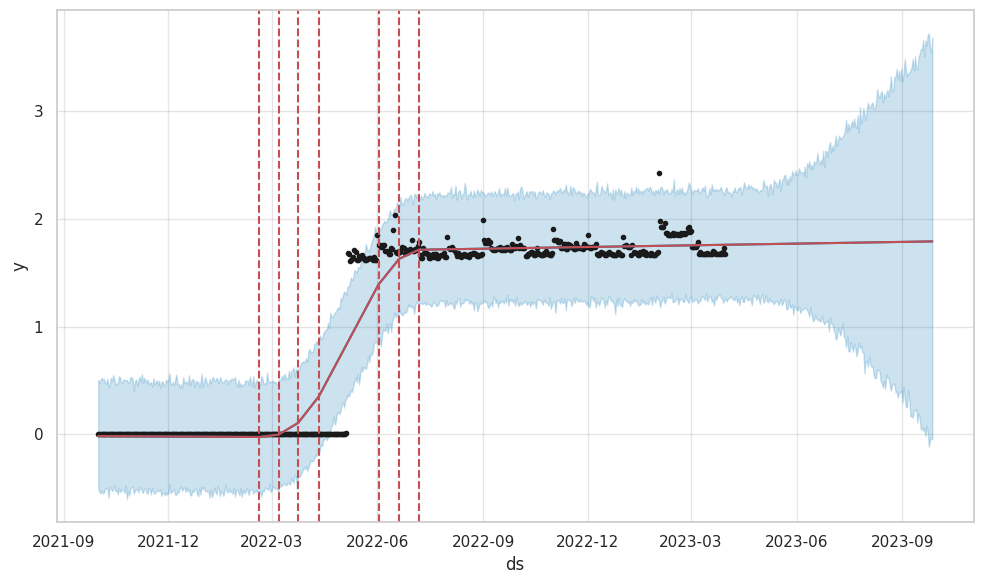

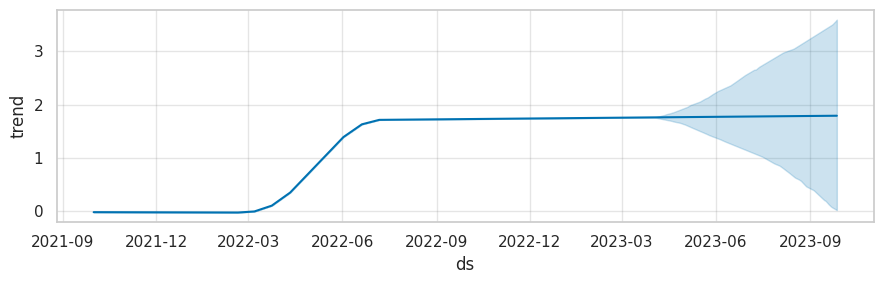

In [99]:
pred_d6 = fit_predict_model(dev_product_6, 180)

23:34:05.999 - DEBUG : input tempfile: /tmp/tmpetdz23jt/vfrao0rf.json
23:34:06.003 - DEBUG : input tempfile: /tmp/tmpetdz23jt/f5w8107e.json
23:34:06.004 - DEBUG : idx 0
23:34:06.004 - DEBUG : running CmdStan, num_threads: None
23:34:06.005 - DEBUG : CmdStan args: ['/mnt/N0326018/.venv/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47061', 'data', 'file=/tmp/tmpetdz23jt/vfrao0rf.json', 'init=/tmp/tmpetdz23jt/f5w8107e.json', 'output', 'file=/tmp/tmpetdz23jt/prophet_model9i8lt4uh/prophet_model-20231010233406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:34:06 - cmdstanpy - INFO - Chain [1] start processing
23:34:06.005 - INFO : Chain [1] start processing
23:34:06 - cmdstanpy - INFO - Chain [1] done processing
23:34:06.040 - INFO : Chain [1] done processing


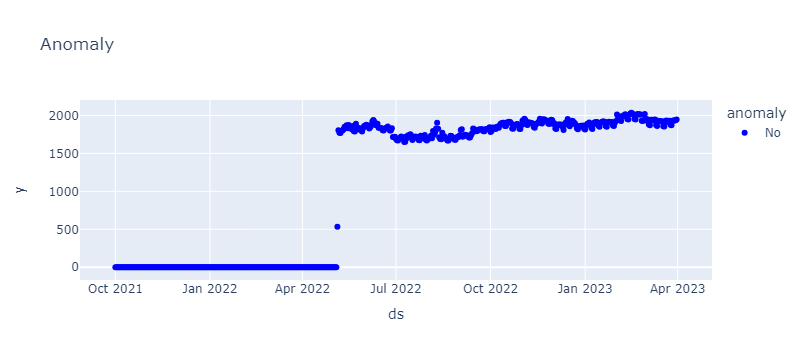

Mean Absolute Error (MAE): 130.53
Median Absolute Error (MedAE): 43.72
Mean Squared Error (MSE): 60555.63
Root Mean Squared Error (RMSE): 246.08
Mean Absolute Percentage Error (MAPE): 0.45 %


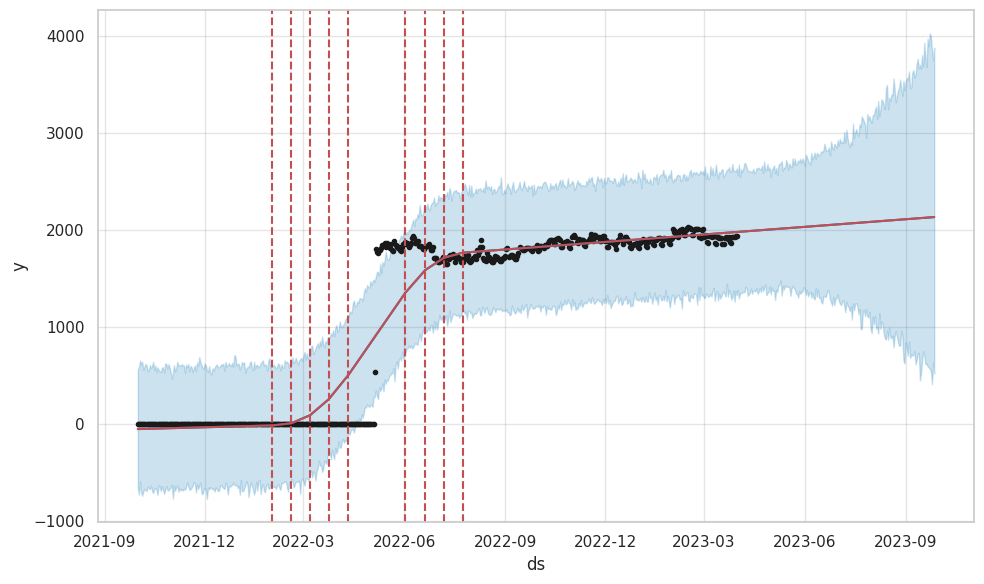

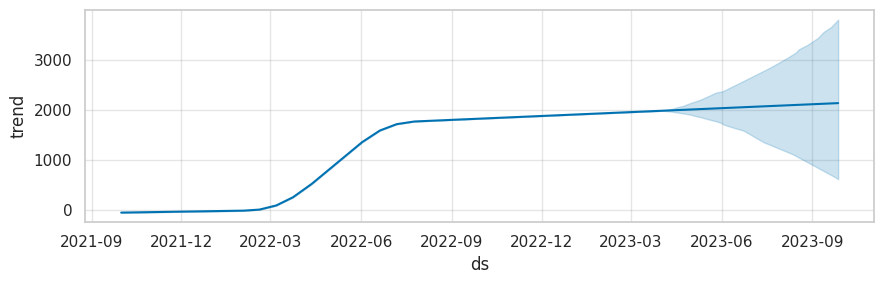

In [100]:
pred_p6 = fit_predict_model(prod_product_6, 180)

23:34:06.862 - DEBUG : input tempfile: /tmp/tmpetdz23jt/pvaydvxo.json
23:34:06.867 - DEBUG : input tempfile: /tmp/tmpetdz23jt/ndyvz3f8.json
23:34:06.868 - DEBUG : idx 0
23:34:06.868 - DEBUG : running CmdStan, num_threads: None
23:34:06.869 - DEBUG : CmdStan args: ['/mnt/N0326018/.venv/lib/python3.9/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7285', 'data', 'file=/tmp/tmpetdz23jt/pvaydvxo.json', 'init=/tmp/tmpetdz23jt/ndyvz3f8.json', 'output', 'file=/tmp/tmpetdz23jt/prophet_modela1j28xu0/prophet_model-20231010233406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:34:06 - cmdstanpy - INFO - Chain [1] start processing
23:34:06.869 - INFO : Chain [1] start processing
23:34:06 - cmdstanpy - INFO - Chain [1] done processing
23:34:06.909 - INFO : Chain [1] done processing


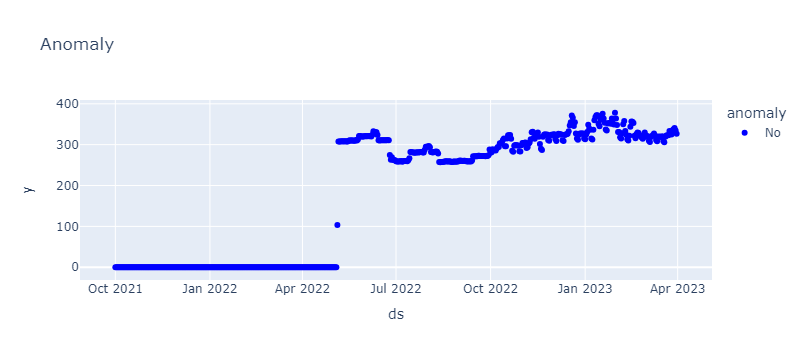

Mean Absolute Error (MAE): 26.56
Median Absolute Error (MedAE): 11.98
Mean Squared Error (MSE): 1970.32
Root Mean Squared Error (RMSE): 44.38
Mean Absolute Percentage Error (MAPE): 0.47 %


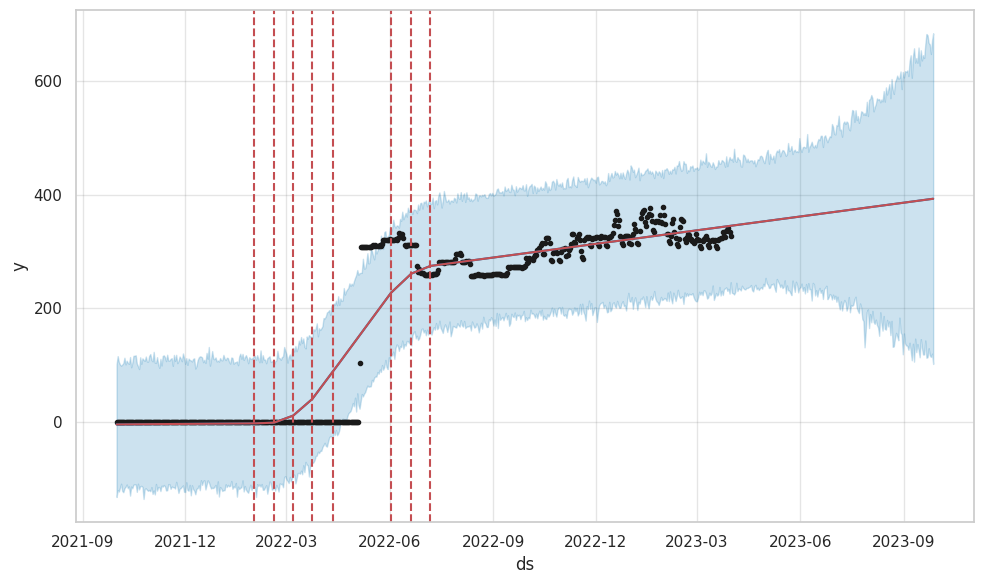

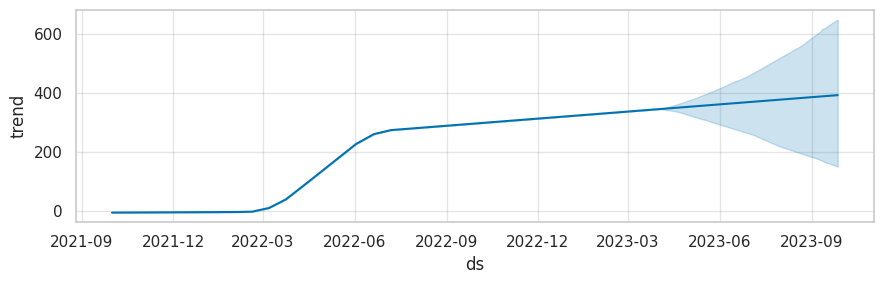

In [101]:
pred_q6 = fit_predict_model(qa_product_6, 180)

In [102]:
# save notebook in HTML format
os.system('jupyter nbconvert --to html rs-cloud-analytics-modeling.ipynb')

[NbConvertApp] Converting notebook rs-cloud-analytics-modeling.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 25 image(s).
[NbConvertApp] Writing 2479516 bytes to rs-cloud-analytics-modeling.html


0

______________________________________________________________________

# Model Evaluation

- Mean Absolute Percentage Error in all forecasts is considered low.
- MAPE < 1% except for Product 1 which is around 1%, then the average difference between the daily forecast and the actual over the whole period is around 1% for Product 1 and less than 1% for the others, which is commonly seen as a very good value.

______________________________________________________________________

# Conclusions/Business Recommendations

My **model strategy** was to understand the most significant products and respective environments, in order to focus on the ones that could mean the highest impact for my client in terms of amortized cost, for the next months.

I decided to use more **granularity** in terms of enviroment, besides product - such as production, development and quality. Did not use testing for first forecasting approach, because it is the most temporary and unstable state.
In terms of products, the ones that covered the majority of usage portfolio was 1, 4, 5, 6.

Based on my **180-day forecast**, my understanding of which spend areas are going to cause growth and/or what are the main drivers of spend increase for my client are:
- In production, products 1, 4 and 6 tend to increase their spend cost
- In development, product 6 is the only one that shows evidence of potential cost increase
- In quality, products 4, 5 and 6 tend to increase their spend cost

In terms of the client’s infrastructure components, the spend areas I believe **it should be priorizited for optimization efforts** are:
- Product 5 in Quality environment shows high evidence of spend growth and should certainly be prioritized for optimization efforts, due to its cost impact
- Product 6 presents a potential growth for all 3 environments
- Product 4 needs attention regarding Production and Quality environments
- Alert: Quality environment tends to be the environment that impacts the most in terms of cost

For **next steps**, in terms of cost I would calculate potential growth rate, ie, (*yhat value* - *y value*)/(*y value*), for the following segments, to be aware of the potential maximum cost:
- Product 5 (Quality)
- Product 6 (Prod, Dev, Qua)
- Product 4 (Prod, Qua)

Also, for next steps, in terms of **cloud cost monitoring**, I would create a PowerBI dahsboard, using my different segment forecasts, to show the client different types of visualizations that would help him prevent and be one step ahead higher costs.

In terms of cloud computing cost mitigation, there are some alerts regarding **anomolous detected spend** in some of the components that should be investigated to prevent/avoid future similar happenings, such as:
- <span style="color:red"> Product 1 (Dev and Prod), between Jan 10th, 2022 to Jan 18th, 2022

______________________________________________________________________

# Reflection

In summary, this notebook conducted a comprehensive analysis of anomaly detection time series, using cost & billing usage report for the past 18 months. Hands-on in data exploration, preprocessing, and feature engineering to prepare the data for modeling. The exploratory data analysis provided valuable insights to decide which segments I would focus on, for future optimization efforts. 
In conclusion, this notebook contains great insights on cloud computing trends and anomalies and successfully forecasted cloud computing cost using Prophets' time series, also detecting data anomalies.

**Future improvements**:
- Apply other time series models to compare performances and explore other perspectives
- Compute forecast for usage amount
- Automate some parts of the code
- Include all notebook functions in utils pyfile, in order to have cleaner notebook, kept for better understading

The analysis and insights presented here can provide valuable guidance for cloud computing cost mitigation.